In [56]:
from riversim import *

outer_boundary = Boundary()
outer_boundary.vertices.extend([Point(0.13, 0.011), Point(0.31, 0), 
    Point(0.74, 0.15), Point(0.95, 0.35), Point(0.8, 0.75), 
    Point(0.47, 0.85), Point(0.152, 0.76), Point(0, 0.5), Point(0.025, 0.3)])
outer_boundary.lines.extend([Line(0, 1, 1), Line(1, 2, 1), 
    Line(2, 3, 1), Line(3, 4, 1), Line(4, 5, 2), Line(5, 6, 2), 
    Line(6, 7, 1), Line(7, 8, 1), Line(8, 0, 1)])

inner_boundary = Boundary()
inner_boundary.vertices.extend([Point(0.3, 0.7), Point(0.5, 0.76), Point(0.65, 0.7), Point(0.66, 0.59)])
inner_boundary.lines.extend([Line(0, 1, 1), Line(1, 2, 3), 
    Line(2, 3, 3), Line(3, 0, 1)])

region = Region()
region[1] = outer_boundary; region[2] = inner_boundary
region.holes.append(Point(0.4, 0.7))

sources = Sources()
sources[1] = t_source_coord(1, 1) 
sources[2] = t_source_coord(1, 8) 
sources[3] = t_source_coord(2, 3)

In [48]:
import matplotlib.pyplot as plt

x = []
y = []
for boundary_pr in region:
    x = x + [v.x for v in boundary_pr.data().vertices]
    y = y + [v.y for v in boundary_pr.data().vertices]
    x.append(boundary_pr.data().vertices[0].x)
    #y.append(boundary_pr.data().vertices[0].y)

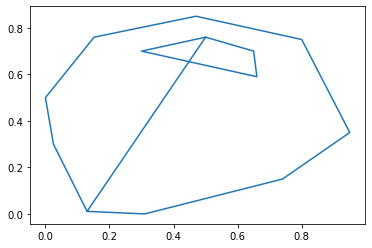

In [49]:
plt.plot(x, y)

In [41]:
rivers = Rivers()
rivers.initialize(region.getSourcesIdsPointsAndAngles(sources))

In [42]:
rivers_ids = t_sources_ids(); rivers_ids.extend([1, 2, 3])
ds = 0.01
tip_points = t_PolarList(); tip_points.extend([Polar(ds, 0), Polar(ds, 0), Polar(ds, 0)])
boundaries_ids = t_boundaries_ids(); boundaries_ids.extend([1, 2, 1])
rivers.addPolars(rivers_ids, tip_points, boundaries_ids)
rivers.addPolars(rivers_ids, tip_points, boundaries_ids)

sub_branch_ids = rivers.createSubBranches(1, -3.1415/5, 3.1415/5)


In [6]:
RegionParams()

{
    "ignored_smoothness_length": 0.01,
    "river_boundary_id": 100,
    "river_width": 1e-07,
    "smoothness_degree": 0.2
}

In [50]:
region_params = RegionParams()
region_params.smoothness_degree = 0.2
region_params.river_width = 1e-8
boundary = BoundaryGenerator(sources, region, rivers, region_params)

In [51]:
import matplotlib.pyplot as plt

x = []
y = []
x = x + [v.x for v in boundary.vertices]
y = y + [v.y for v in boundary.vertices]
x.append(boundary.vertices[0].x)
y.append(boundary.vertices[0].y)

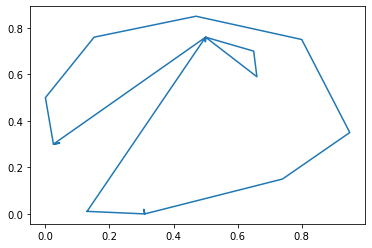

In [52]:
plt.plot(x, y)

In [20]:
mesh_params = MeshParams()
mesh_params.max_area = 1e6
mesh_params.min_area = 6e-7
mesh_params.max_edge = 1
mesh_params.min_edge = 8e-12
mesh_params.ratio = 2.3
mesh_params.refinment_radius = 5e-3
mesh_params.exponant = 1
mesh_params.sigma = 1.9

In [21]:
triangle = Triangle(mesh_params)

In [22]:
mesh = triangle.generate(boundary, region.holes)

In [23]:
mesh.write("lala.msh")

In [66]:
solver_params = SolverParams()
solver_params.field_value = 1
solver_params.quadrature_degree = 3
solver_params.renumbering_type = 0
solver_params.tollerance = 1e-12
solver_params.num_of_iterrations =  6000
solver_params.refinment_fraction = 0.1

solver = Solver(solver_params)

solver.openMesh(mesh)

In [62]:
solver_params

{
    "adaptive_refinment_steps": 0,
    "field_value": 1.0,
    "num_of_iterrations": 6000,
    "quadrature_degree": 3,
    "refinment_fraction": 0.1,
    "renumbering_type": 0,
    "static_refinment_steps": 0,
    "tollerance": 1e-12
}

In [ ]:
integration_params = IntegrationParams()
integration_params.eps = 1e-10
integration_params.integration_radius = 3e-2
integration_params.exponant = 2.0
integration_params.weigth_func_radius = 1e-2


tip_point = rivers[1].tipPoint()
tip_angle = rivers[1].tipAngle()

ids_series_params = t_ids_series_params()
ids_series_params[1] = solver.integrate_new(integration_params, tip_point, tip_angle)

: 

: 

In [144]:
np.logspace(-1, -9, 10)

array([1.00000000e-01, 1.29154967e-02, 1.66810054e-03, 2.15443469e-04,
       2.78255940e-05, 3.59381366e-06, 4.64158883e-07, 5.99484250e-08,
       7.74263683e-09, 1.00000000e-09])

In [11]:
import riversim
import numpy as np


par = np.logspace(0, -2, 10)
a1_ev = []
a1_a = []
dev_in_per = []
mesh_size = []

for p in par:

    model = riversim.Model()
    model.height = 50; model.width = 2; model.dx = 1;
    model.initializeLaplace()

    H = 1
    model.solver_params.adaptive_refinment_steps = 1
    model.rivers[1].addPoint(riversim.Polar(H, 0), 0)
    
    boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, model.region_params)
    triangle = riversim.Triangle(model.mesh_params)
    triangle.mesh_params.refinment_radius = 0.002
    triangle.mesh_params.exponant = 2
    triangle.mesh_params.min_area = 1e-9
    triangle.mesh_params.tip_points = model.rivers.tipPoints()
    mesh = triangle.generate(boundary, model.region.holes)
    mesh.write("test" + str(p) + ".msh")
    model.solver_params.quadrature_degree = 4
    solver = riversim.Solver(model.solver_params)
    solver.openMesh(mesh)
    for i in range(1 + model.solver_params.adaptive_refinment_steps):
        if i > 0:
            solver.refineGrid()
        solver.setupSystem()
        solver.assembleSystem(model.boundary_conditions)
        solver.solve()

    tip_angle = model.rivers[1].tipAngle()
    tip_coord = model.rivers[1].tipPoint()

    #series_params_old = solver.integrate(model.integr_params, tip_coord, tip_angle)
    #series_params_new = solver.integrate_new(model.integr_params, tip_coord, tip_angle)
    model.integr_params.eps = p
    model.integr_params.integration_radius = 0.0001
    model.integr_params.weigth_func_radius = 0.003
    series_params_trap = solver.integrate_trap(model.integr_params, tip_coord, tip_angle)
    a_analitic = np.sqrt(4/np.pi*np.tanh(np.pi/2 * H))
    #print(series_params_old[0])
    #print(series_params_new[0])
    print(series_params_trap[0])
    print(a_analitic)
    a1_ev += [series_params_trap[0]]
    a1_a += [a_analitic]
    mesh_size += [mesh.getNQuadrangles()]
    dev_in_per += [100 * abs((1 - series_params_trap[0] / a_analitic))]
    print(100*(1 - series_params_trap[0] / a_analitic))

1.087557516654412
1.0806269579821668
-0.6413460834982843
1.0809547373030373
1.0806269579821668
-0.030332328695781285
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432
1.0806694159478307
1.0806269579821668
-0.003929012259984432


In [141]:
dev_in_per

[60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863,
 60.87383703559863]

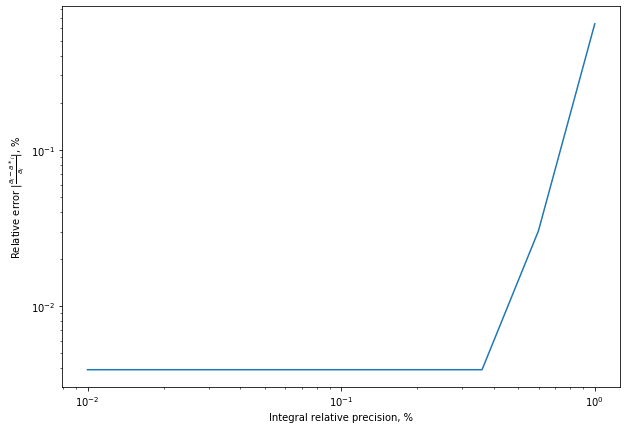

In [12]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral relative precision, %")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

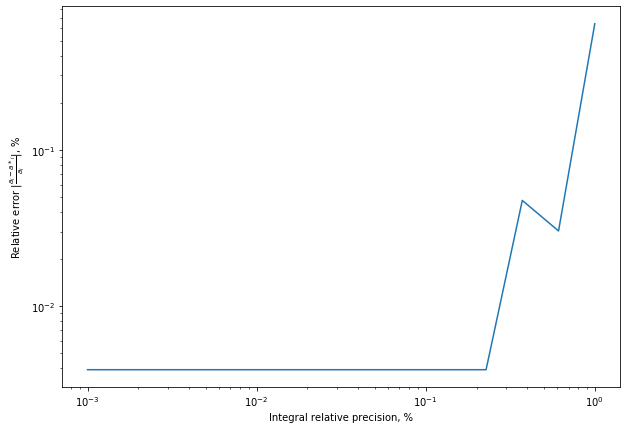

In [10]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral relative precision, %")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

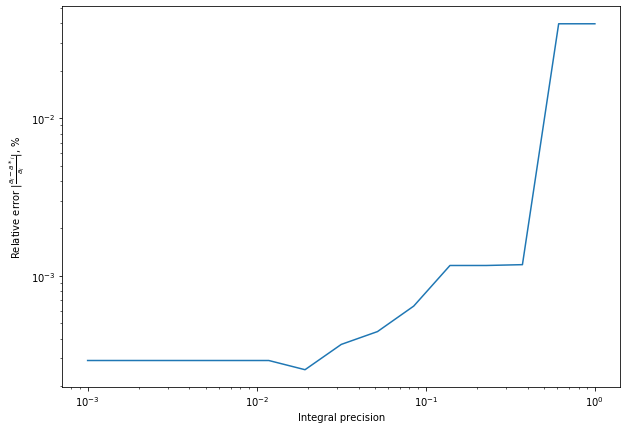

In [5]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral precision")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

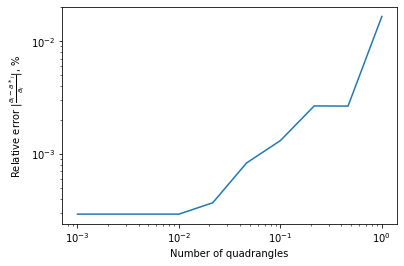

In [2]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Integral precision")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

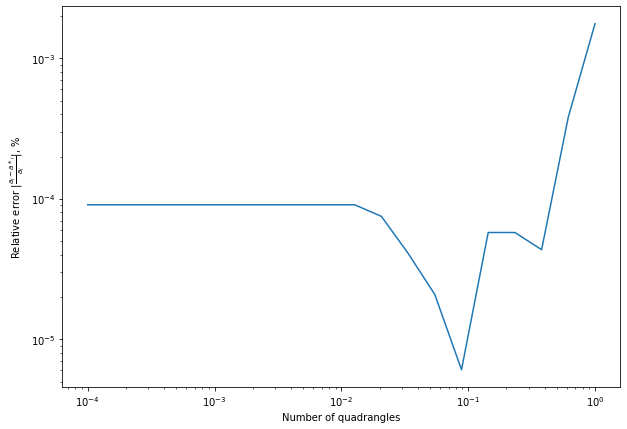

In [171]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Number of quadrangles")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

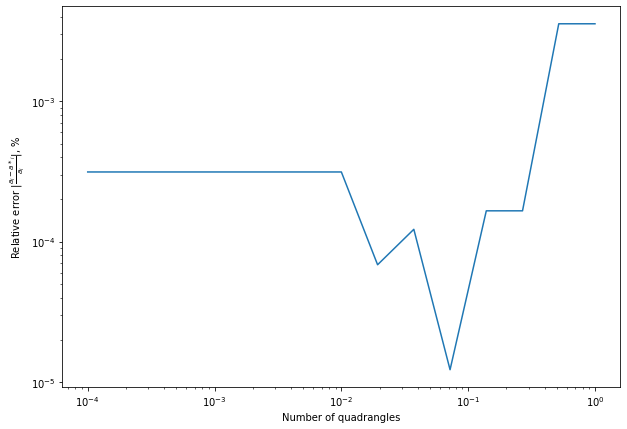

In [169]:
import matplotlib.pyplot as plt
plt.loglog(par, dev_in_per)
plt.ylabel(r'Relative error $|\frac{a_i - a*_i}{a_i}|$, %')
plt.xlabel("Number of quadrangles")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig("convergence_by_integral_precision.png")

# Симуляції в Апендексі

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
{'bound_gen_t': array([-6.50882721e-05, -4.55379486e-05, -3.48091125e-05, -3.91006470e-05,
       -6.15119934e-05, -3.91006470e-05, -4.19616699e-05, -4.43458557e-05,
       -5.72204590e-05, -4.43458557e-05, -4.83989716e-05, -5.14984131e-05,
       -7.46250153e-05, -6.34193420e-05, -6.62803650e-05, -4.72068787e-05,
       -4.76837158e-05, -8.08238983e-05, -5.86509705e-05, -5.72204590e-05,
       -7.36713409e-05, -9.67979431e-05, -7.15255737e-05, -1.43051147e-04,
       -7.31945038e-05, -1.08242035e-04, -1.54972076e-04, -9.03606415e-05,
       -7.89165497e-05, -8.05854797e-05, -9.36985016e-05, -1.03235245e-04,
       -1.81674957e-04, -9.27448273e-05, -8.63075256e-05, -8.82148743e-05,
       -1.58071518e-04, -1.25408173e-04, -1.03473663e-04, -1.59502029e-04,
       -9.65595245e-05, -1.41382217e-04, -2.21729279e-04, -1.97887421e-04,
       -9.82284546e-05, -1.07765198e-04, -1.24216080e-04, -1.51872635e-04,
      

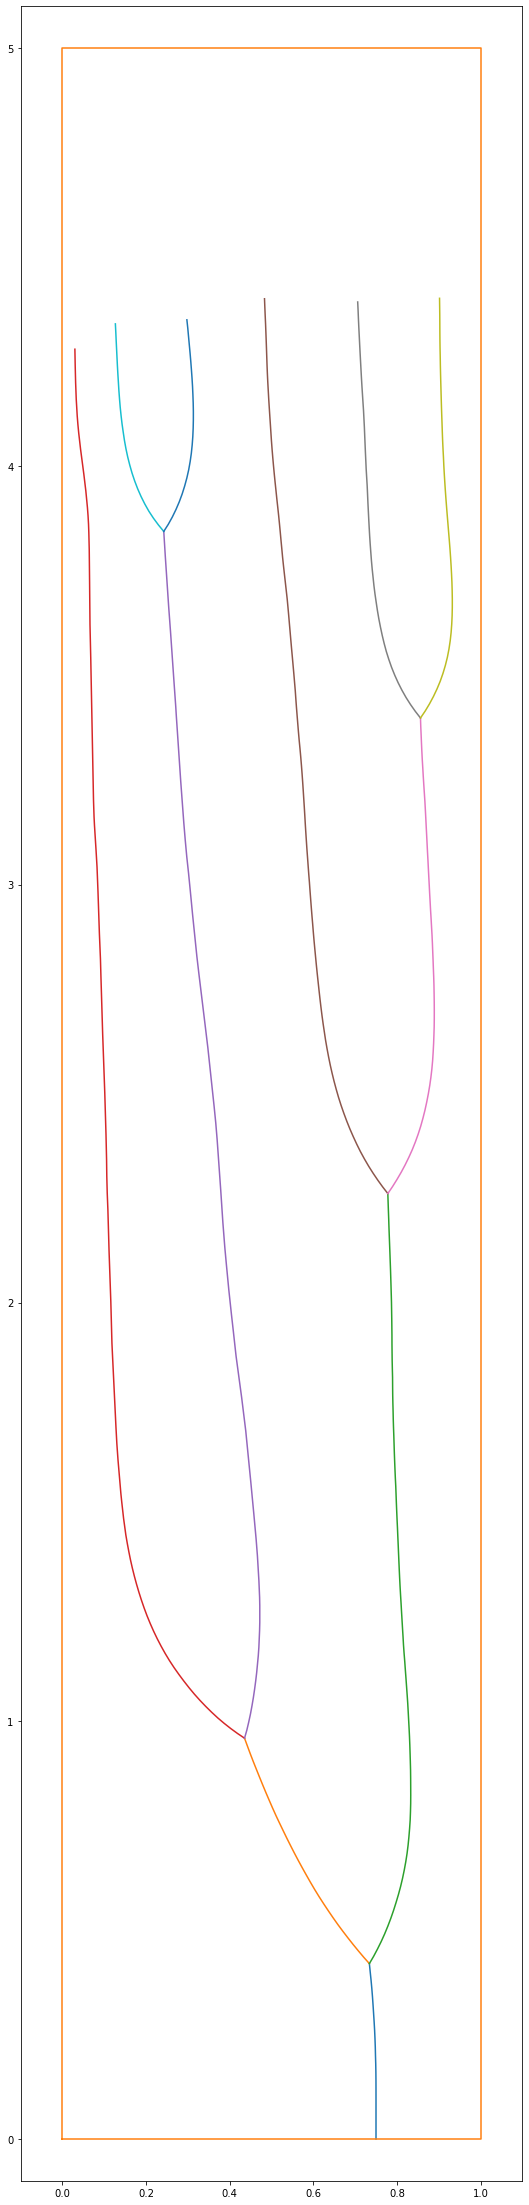

In [35]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 0

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_0.json")
plt.gcf().savefig("laplacian_field_eta_0.png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
{'bound_gen_t': array([-9.15527344e-05, -5.34057617e-05, -5.48362732e-05, -5.84125519e-05,
       -5.91278076e-05, -5.62667847e-05, -5.79357147e-05, -5.60283661e-05,
       -9.60826874e-05, -6.22272491e-05, -9.20295715e-05, -6.48498535e-05,
       -5.88893890e-05, -6.93798065e-05, -6.19888306e-05, -7.41481781e-05,
       -6.50882721e-05, -7.36713409e-05, -9.44137573e-05, -7.72476196e-05,
       -8.74996185e-05, -1.14679337e-04, -8.67843628e-05, -8.44001770e-05,
       -8.72612000e-05, -9.77516174e-05, -1.10626221e-04, -9.91821289e-05,
       -1.17301941e-04, -1.42812729e-04, -1.05142593e-04, -1.02519989e-04,
       -1.09910965e-04, -1.05857849e-04, -1.11818314e-04, -1.14440918e-04,
       -1.14202499e-04, -1.21355057e-04, -1.17778778e-04, -1.21831894e-04,
       -1.31130219e-04, -1.27315521e-04, -1.40190125e-04, -1.67608261e-04,
       -2.62260437e-04, -1.29222870e-04, -1.49250031e-04, -1.3232

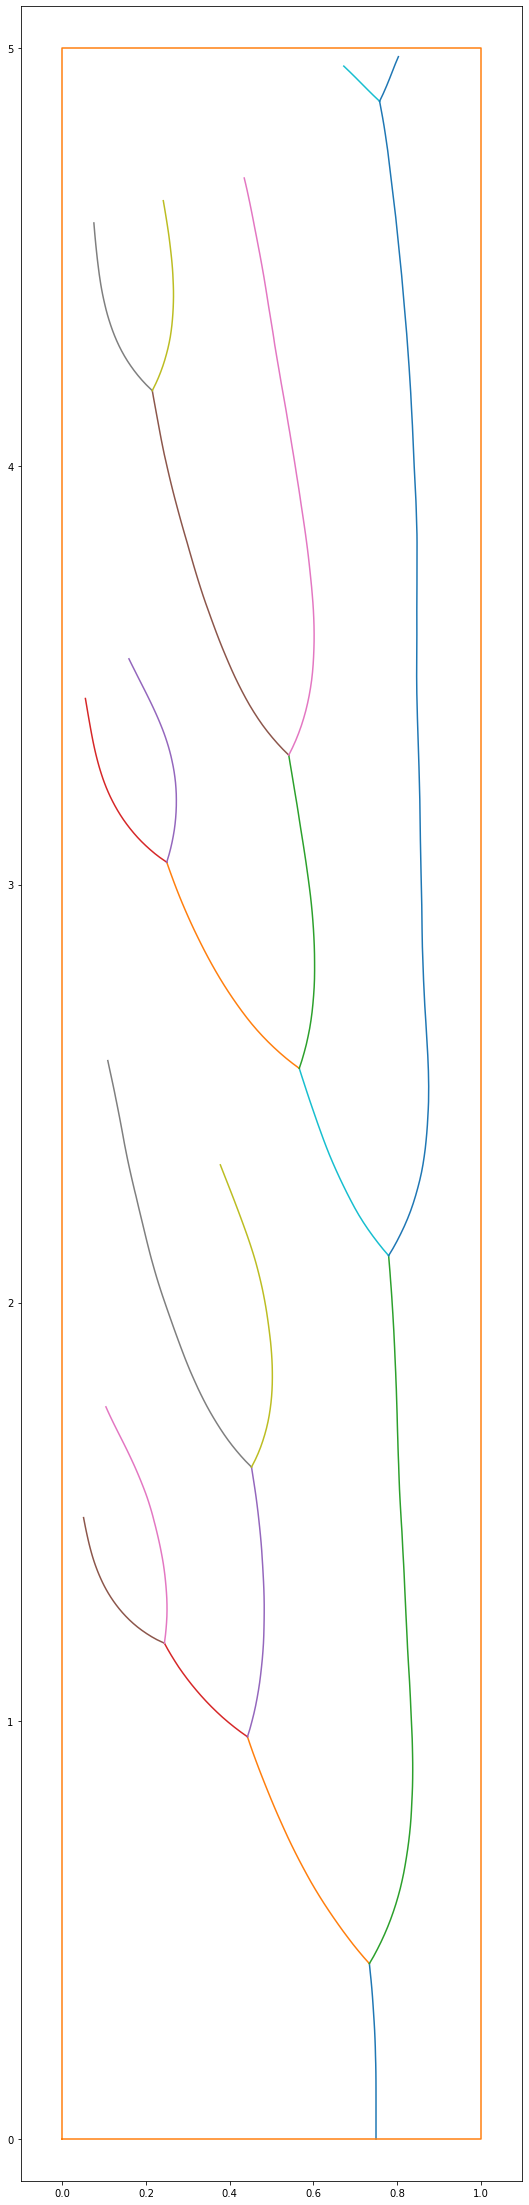

In [36]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 0.5

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_0.5.json")
plt.gcf().savefig("laplacian_field_eta_0.5.png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
{'bound_gen_t': array([-5.48362732e-05, -4.10079956e-05, -4.19616699e-05, -4.36306000e-05,
       -4.33921814e-05, -1.01566315e-04, -4.38690186e-05, -5.74588776e-05,
       -4.38690186e-05, -6.98566437e-05, -1.31368637e-04, -7.27176666e-05,
       -7.77244568e-05, -8.70227814e-05, -8.05854797e-05, -7.77244568e-05,
       -5.26905060e-05, -1.03473663e-04, -6.27040863e-05, -9.79900360e-05,
       -6.62803650e-05, -8.20159912e-05, -7.29560852e-05, -7.08103180e-05,
       -7.65323639e-05, -7.65323639e-05, -7.36713409e-05, -7.65323639e-05,
       -8.20159912e-05, -8.86917114e-05, -1.21116638e-04, -1.13010406e-04,
       -9.08374786e-05, -8.15391541e-05, -1.12295151e-04, -1.05619431e-04,
       -1.03235245e-04, -1.31845474e-04, -1.61886215e-04, -1.16825104e-04,
       -1.18970871e-04, -1.96218491e-04, -1.43051147e-04, -1.38998032e-04,
       -2.31981277e-04, -1.91926956e-04, -2.01225281e-04, -2.0575

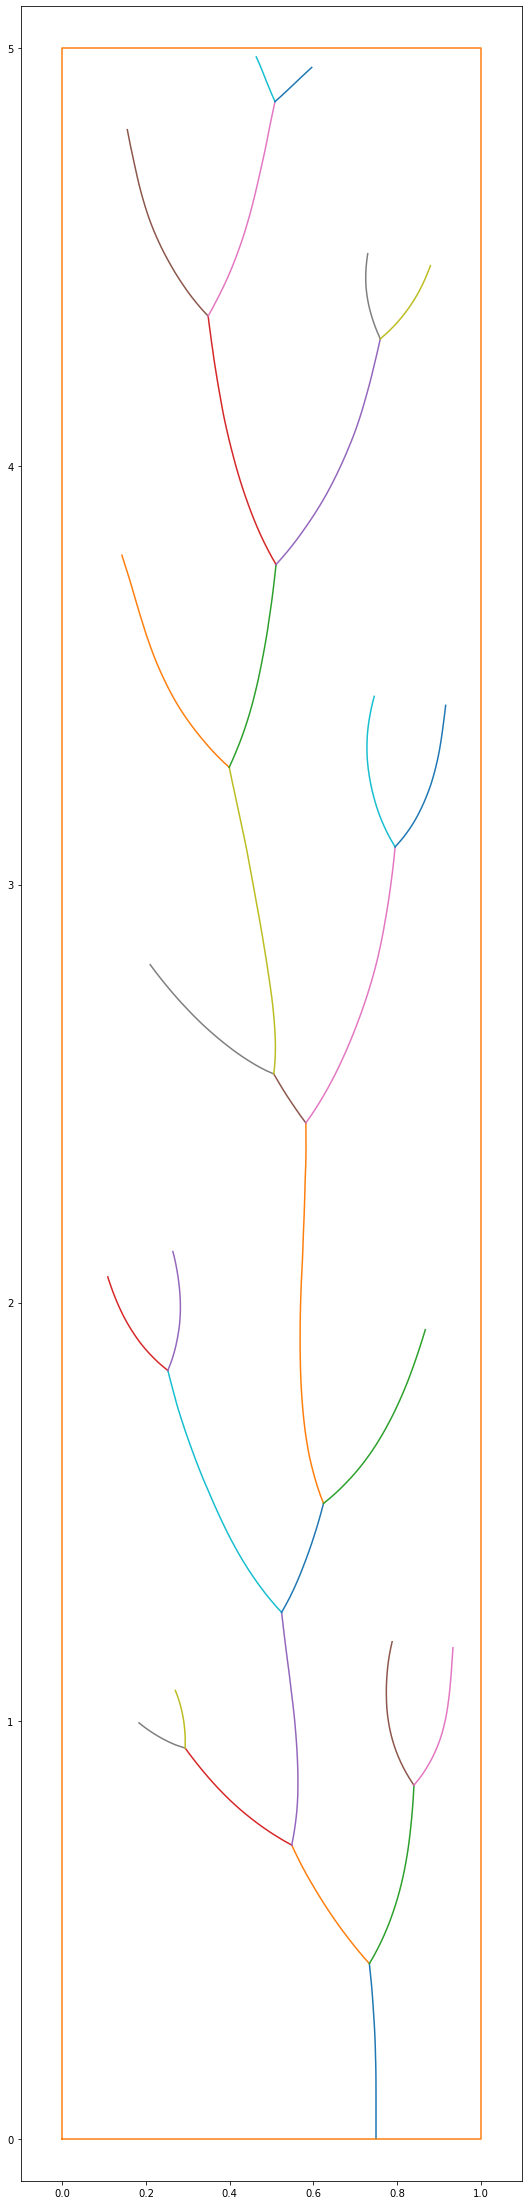

In [39]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 1

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_1.json")

plt.gcf().savefig("laplacian_field_eta_1.png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
{'bound_gen_t': array([-4.67300415e-05, -4.14848328e-05, -4.05311584e-05, -4.33921814e-05,
       -4.86373901e-05, -4.60147858e-05, -4.50611115e-05, -5.26905060e-05,
       -5.10215759e-05, -5.74588776e-05, -4.91142273e-05, -5.41210175e-05,
       -5.41210175e-05, -7.70092010e-05, -5.98430634e-05, -5.65052032e-05,
       -5.05447388e-05, -1.17540359e-04, -5.91278076e-05, -6.86645508e-05,
       -7.55786896e-05, -6.86645508e-05, -6.55651093e-05, -7.72476196e-05,
       -7.22408295e-05, -7.67707825e-05, -8.48770142e-05, -7.91549683e-05,
       -7.79628754e-05, -8.48770142e-05, -1.14202499e-04, -8.48770142e-05,
       -8.36849213e-05, -8.53538513e-05, -8.46385956e-05, -9.79900360e-05,
       -1.04665756e-04, -1.13487244e-04, -1.02281570e-04, -1.10626221e-04,
       -1.11103058e-04, -1.19209290e-04, -1.20162964e-04, -1.27792358e-04,
       -1.42335892e-04, -1.54018402e-04, -1.53064728e-04, -1.3232

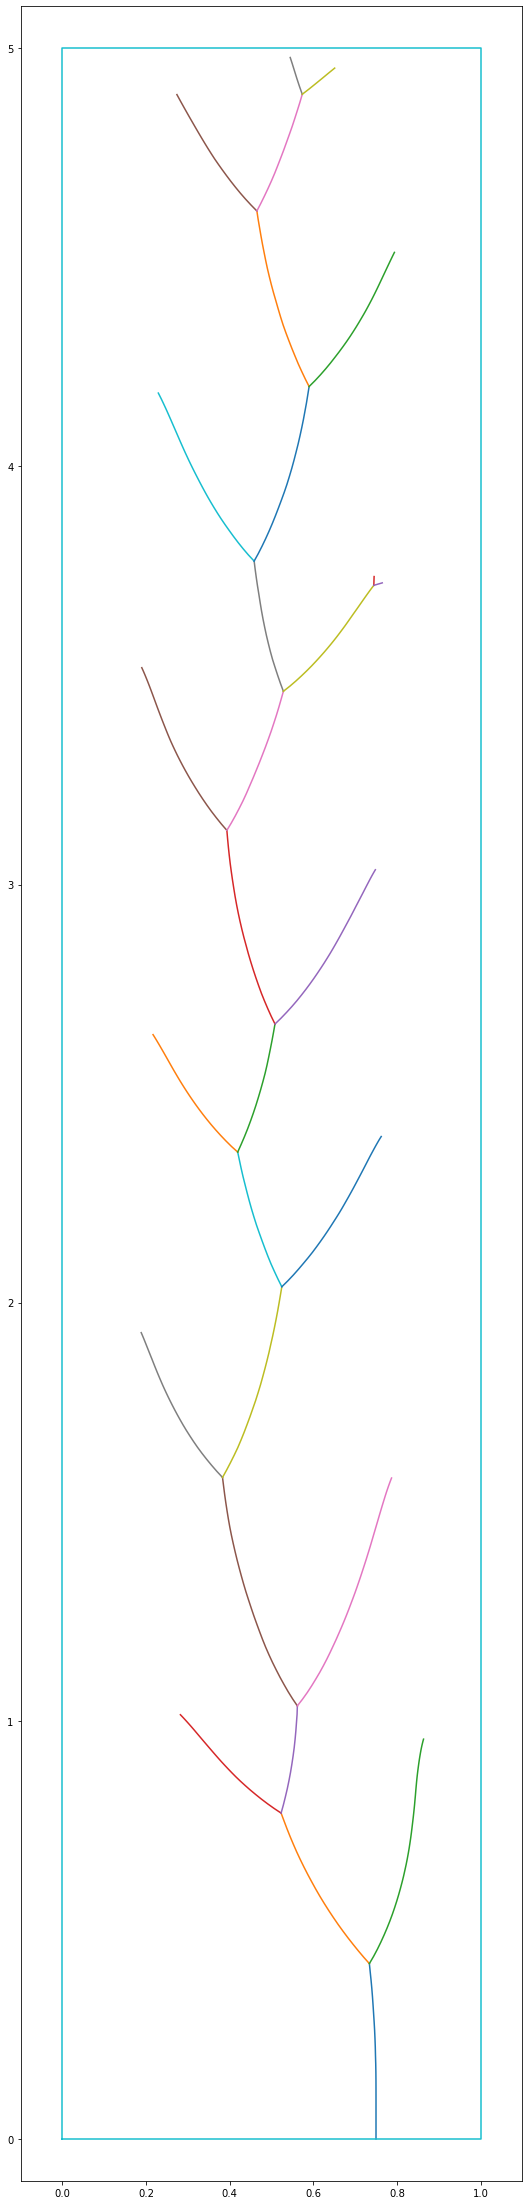

In [40]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 1.5

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_1.5.json")

plt.gcf().savefig("laplacian_field_eta_1.5.png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
{'bound_gen_t': array([-5.07831573e-05, -7.70092010e-05, -5.19752502e-05, -5.65052032e-05,
       -8.94069672e-05, -5.69820404e-05, -6.31809235e-05, -7.05718994e-05,
       -6.19888306e-05, -5.98430634e-05, -8.24928284e-05, -6.17504120e-05,
       -6.12735748e-05, -6.77108765e-05, -6.19888306e-05, -6.15119934e-05,
       -6.38961792e-05, -8.53538513e-05, -7.55786896e-05, -1.03950500e-04,
       -8.41617584e-05, -8.34465027e-05, -8.65459442e-05, -8.82148743e-05,
       -9.32216644e-05, -9.77516174e-05, -9.65595245e-05, -1.02758408e-04,
       -1.09195709e-04, -1.00374222e-04, -1.04665756e-04, -1.24692917e-04,
       -1.06096268e-04, -1.08242035e-04, -1.14917755e-04, -1.19924545e-04,
       -1.18017197e-04, -1.19209290e-04, -1.43289566e-04, -1.55448914e-04,
       -1.24216080e-04, -1.23739243e-04, -1.20878220e-04, -1.76906586e-04,
       -1.67846680e-04, -1.42812729e-04, -1.58071518e-04, -1.5616

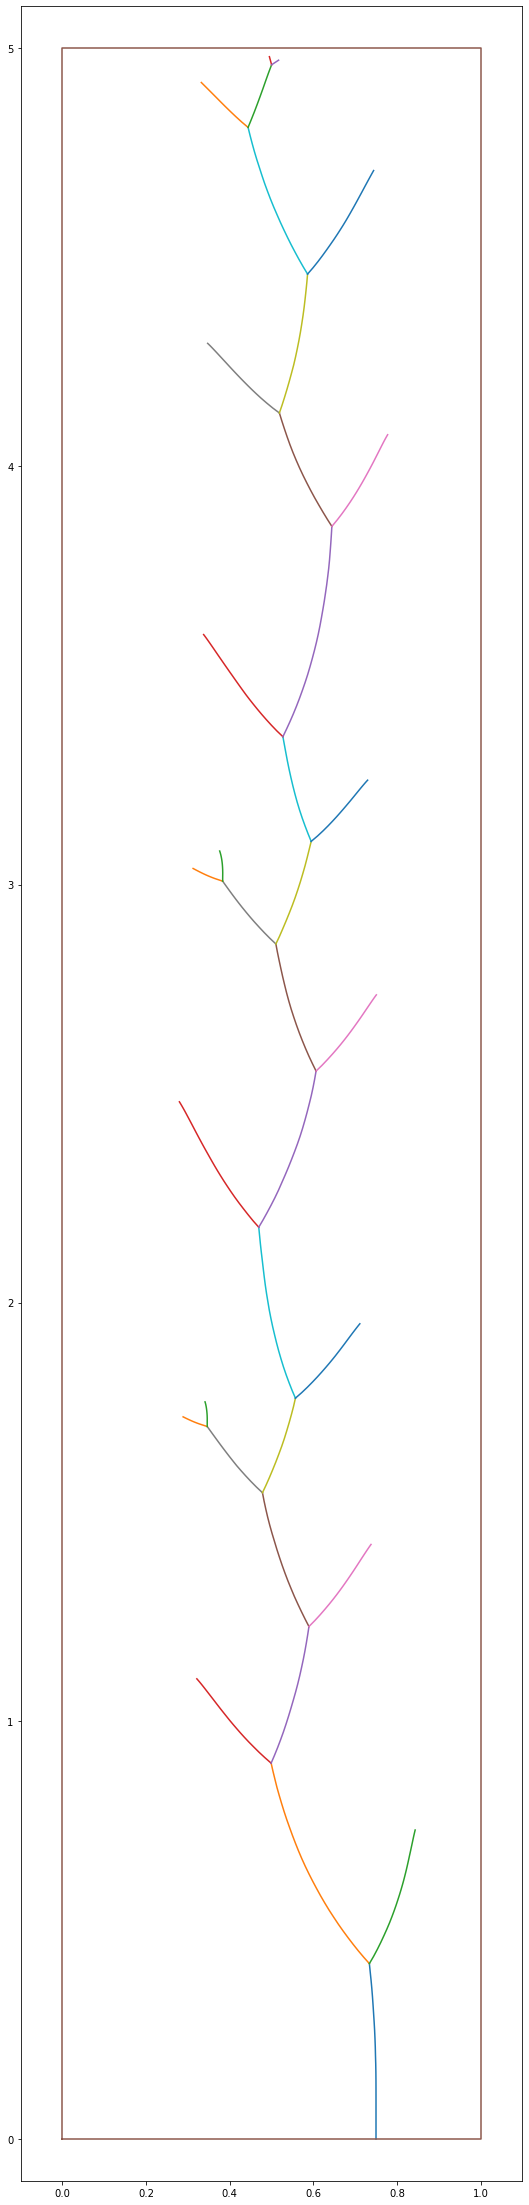

In [41]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 2

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_2.json")

plt.gcf().savefig("laplacian_field_eta_2.png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
{'bound_gen_t': array([-6.60419464e-05, -4.93526459e-05, -4.95910645e-05, -5.22136688e-05,
       -5.62667847e-05, -5.84125519e-05, -5.86509705e-05, -5.62667847e-05,
       -7.62939453e-05, -6.19888306e-05, -6.86645508e-05, -6.74724579e-05,
       -6.31809235e-05, -7.05718994e-05, -6.48498535e-05, -6.79492950e-05,
       -7.79628754e-05, -1.00135803e-04, -7.98702240e-05, -7.65323639e-05,
       -1.18255615e-04, -8.41617584e-05, -9.01222229e-05, -8.74996185e-05,
       -1.01566315e-04, -2.09093094e-04, -9.53674316e-05, -1.00374222e-04,
       -1.25646591e-04, -1.11103058e-04, -1.05381012e-04, -1.11103058e-04,
       -1.45435333e-04, -1.08957291e-04, -1.30176544e-04, -1.25885010e-04,
       -1.30653381e-04, -1.35183334e-04, -1.41382217e-04, -1.41143799e-04,
       -1.56164169e-04, -2.28404999e-04, -1.56402588e-04, -1.51634216e-04,
       -2.31027603e-04, -1.85012817e-04, -1.94787979e-04, -1.9860

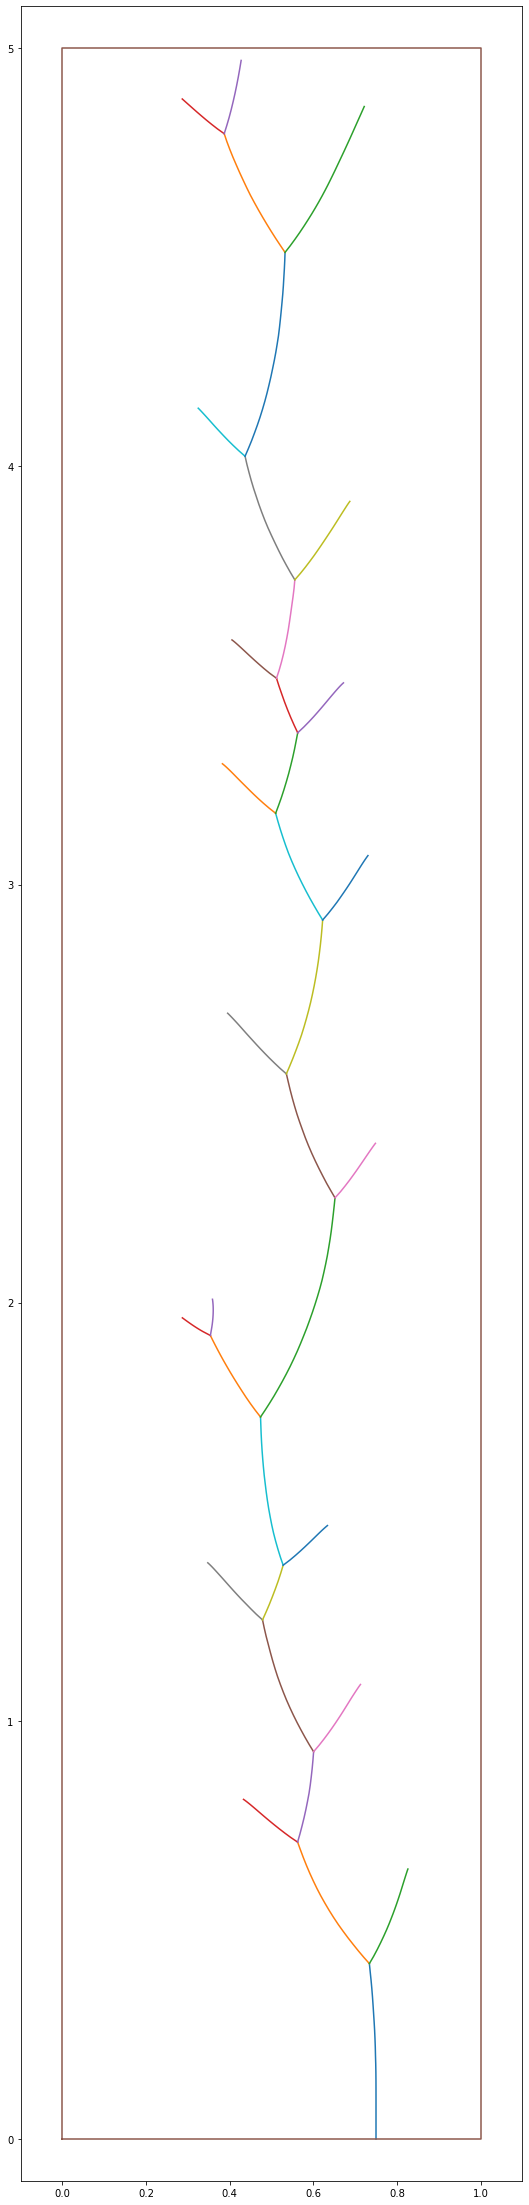

In [42]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 2.5

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_2.5.json")

plt.gcf().savefig("laplacian_field_eta_2.5.png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
{'bound_gen_t': array([-8.32080841e-05, -5.07831573e-05, -3.71932983e-05, -1.07288361e-04,
       -3.86238098e-05, -4.55379486e-05, -1.26361847e-04, -9.60826874e-05,
       -7.24792480e-05, -4.45842743e-05, -4.50611115e-05, -7.58171082e-05,
       -6.98566437e-05, -4.64916229e-05, -4.86373901e-05, -4.41074371e-05,
       -6.34193420e-05, -5.57899475e-05, -5.98430634e-05, -6.41345978e-05,
       -6.17504120e-05, -1.09434128e-04, -1.05381012e-04, -5.93662262e-05,
       -6.74724579e-05, -7.62939453e-05, -7.10487366e-05, -7.60555267e-05,
       -7.00950623e-05, -7.24792480e-05, -1.00851059e-04, -1.00612640e-04,
       -1.09195709e-04, -8.05854797e-05, -7.46250153e-05, -9.27448273e-05,
       -1.42574310e-04, -1.09195709e-04, -1.14679337e-04, -1.18494034e-04,
       -1.15633011e-04, -1.69038773e-04, -1.91926956e-04, -2.87294388e-04,
       -1.44004822e-04, -1.55925751e-04, -2.74896622e-04, -2.2745

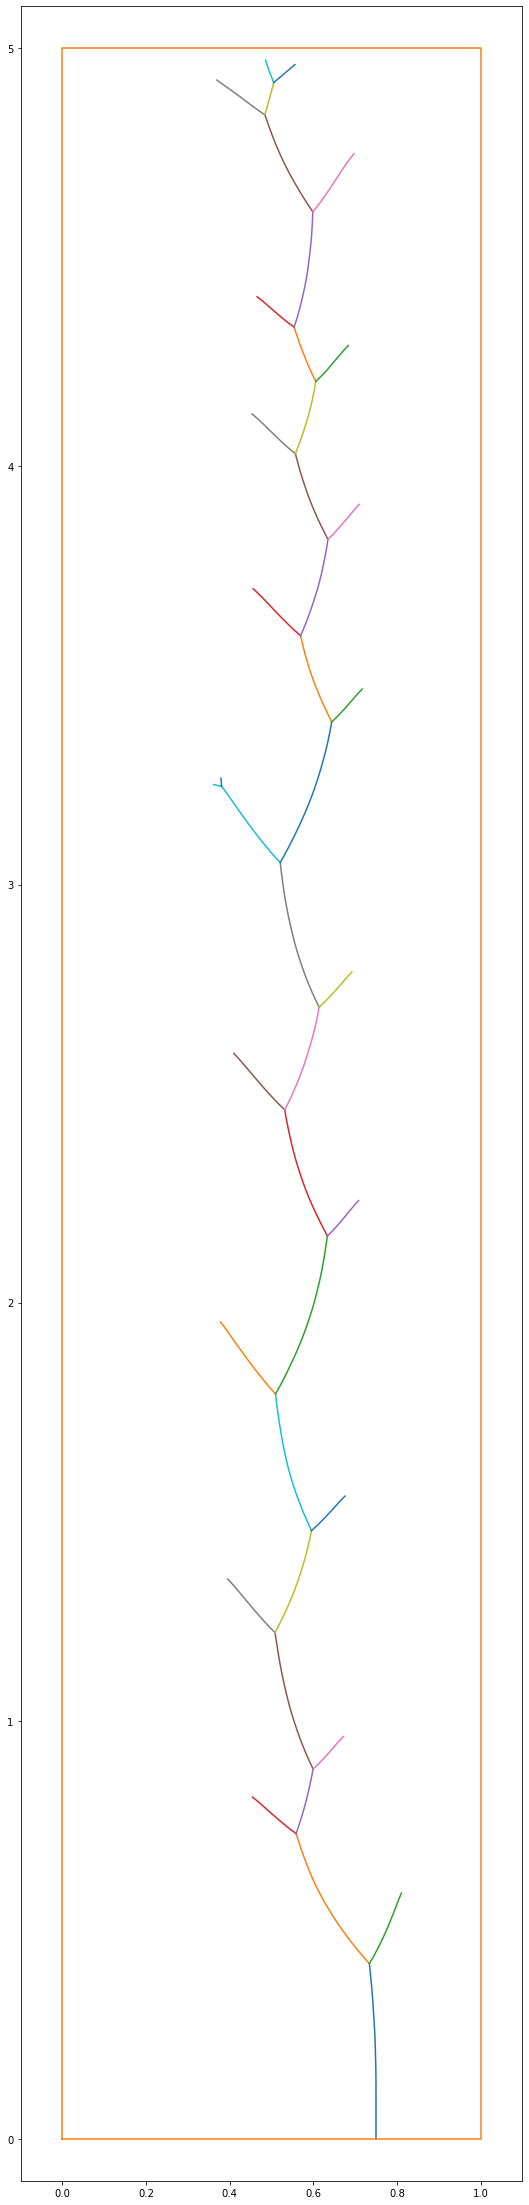

In [44]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 5
m.width = 1
m.dx = 0.75
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 3

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_field_eta_3.json")

plt.gcf().savefig("laplacian_field_eta_3.png")

0
10
20
30
40
50
60
{'bound_gen_t': array([-5.22136688e-05, -7.36713409e-05, -7.00950623e-05, -5.29289246e-05,
       -7.36713409e-05, -6.22272491e-05, -6.12735748e-05, -6.00814819e-05,
       -5.53131104e-05, -6.03199005e-05, -7.20024109e-05, -7.00950623e-05,
       -7.39097595e-05, -7.36713409e-05, -1.10387802e-04, -8.01086426e-05,
       -7.77244568e-05, -8.82148743e-05, -8.48770142e-05, -8.67843628e-05,
       -9.58442688e-05, -9.39369202e-05, -8.98838043e-05, -9.17911530e-05,
       -1.16348267e-04, -1.17063522e-04, -1.28984451e-04, -1.20878220e-04,
       -1.85728073e-04, -1.38521194e-04, -1.52826309e-04, -1.59502029e-04,
       -1.78813934e-04, -1.66893005e-04, -1.74522400e-04, -2.03132629e-04,
       -2.06708908e-04, -2.15053558e-04, -2.30312347e-04, -2.47240067e-04,
       -2.64883041e-04, -2.95162201e-04, -2.79188156e-04, -2.75611877e-04,
       -2.69651413e-04, -4.17232513e-04, -3.66449356e-04, -4.68015671e-04,
       -5.19037247e-04, -4.08649445e-04, -4.36782837e-04, -4.467

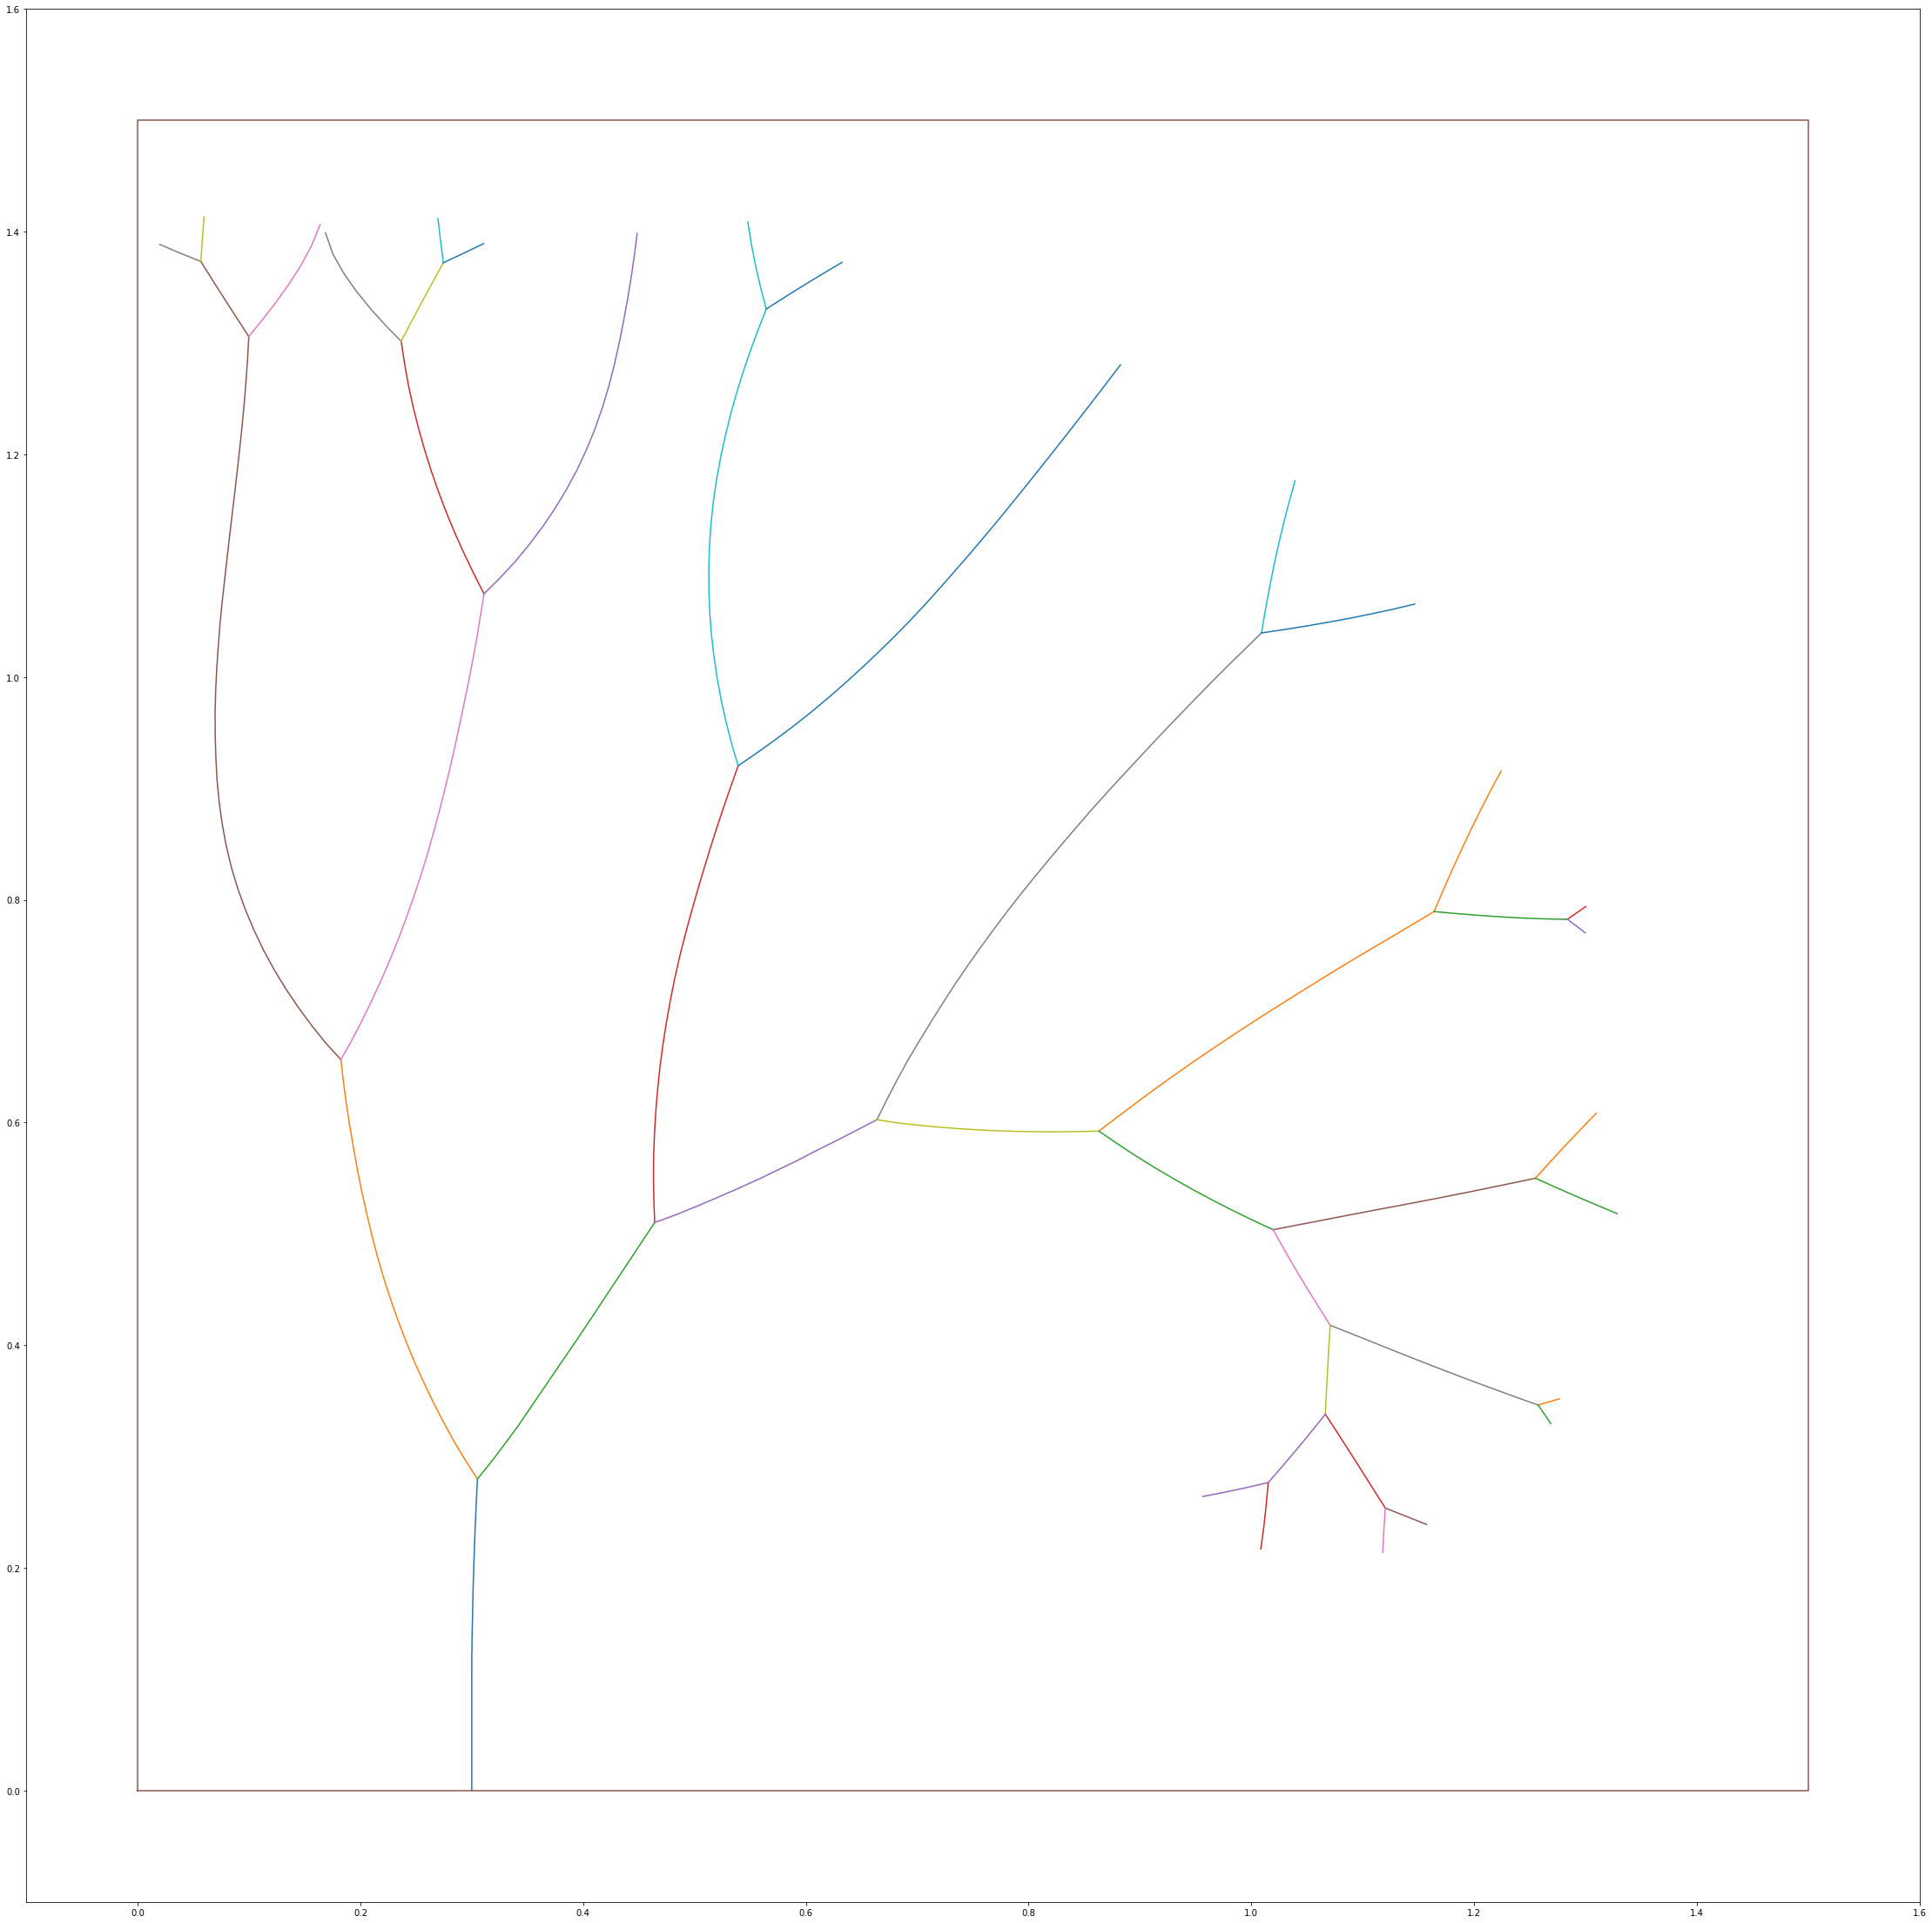

In [45]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 0

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_0.json")

plt.gcf().savefig("poisson_field_eta_0.png")

0
10
20
30
40
50
60
70
80
{'bound_gen_t': array([-5.12599945e-05, -4.91142273e-05, -7.05718994e-05, -7.43865967e-05,
       -5.29289246e-05, -4.91142273e-05, -5.05447388e-05, -4.50611115e-05,
       -5.53131104e-05, -5.45978546e-05, -6.05583191e-05, -5.69820404e-05,
       -5.96046448e-05, -6.12735748e-05, -7.79628754e-05, -7.22408295e-05,
       -6.36577606e-05, -7.98702240e-05, -7.58171082e-05, -7.27176666e-05,
       -7.65323639e-05, -1.00135803e-04, -8.96453857e-05, -9.10758972e-05,
       -9.82284546e-05, -1.07765198e-04, -1.37805939e-04, -1.02996826e-04,
       -1.41382217e-04, -1.04188919e-04, -1.99556351e-04, -1.20162964e-04,
       -1.44004822e-04, -1.68085098e-04, -2.73466110e-04, -1.82867050e-04,
       -1.41143799e-04, -1.54256821e-04, -1.55210495e-04, -1.66893005e-04,
       -1.63316727e-04, -1.78337097e-04, -2.09808350e-04, -2.59876251e-04,
       -3.77655029e-04, -3.49998474e-04, -2.96115875e-04, -3.34024429e-04,
       -3.63826752e-04, -3.79323959e-04, -4.27722931e-04, 

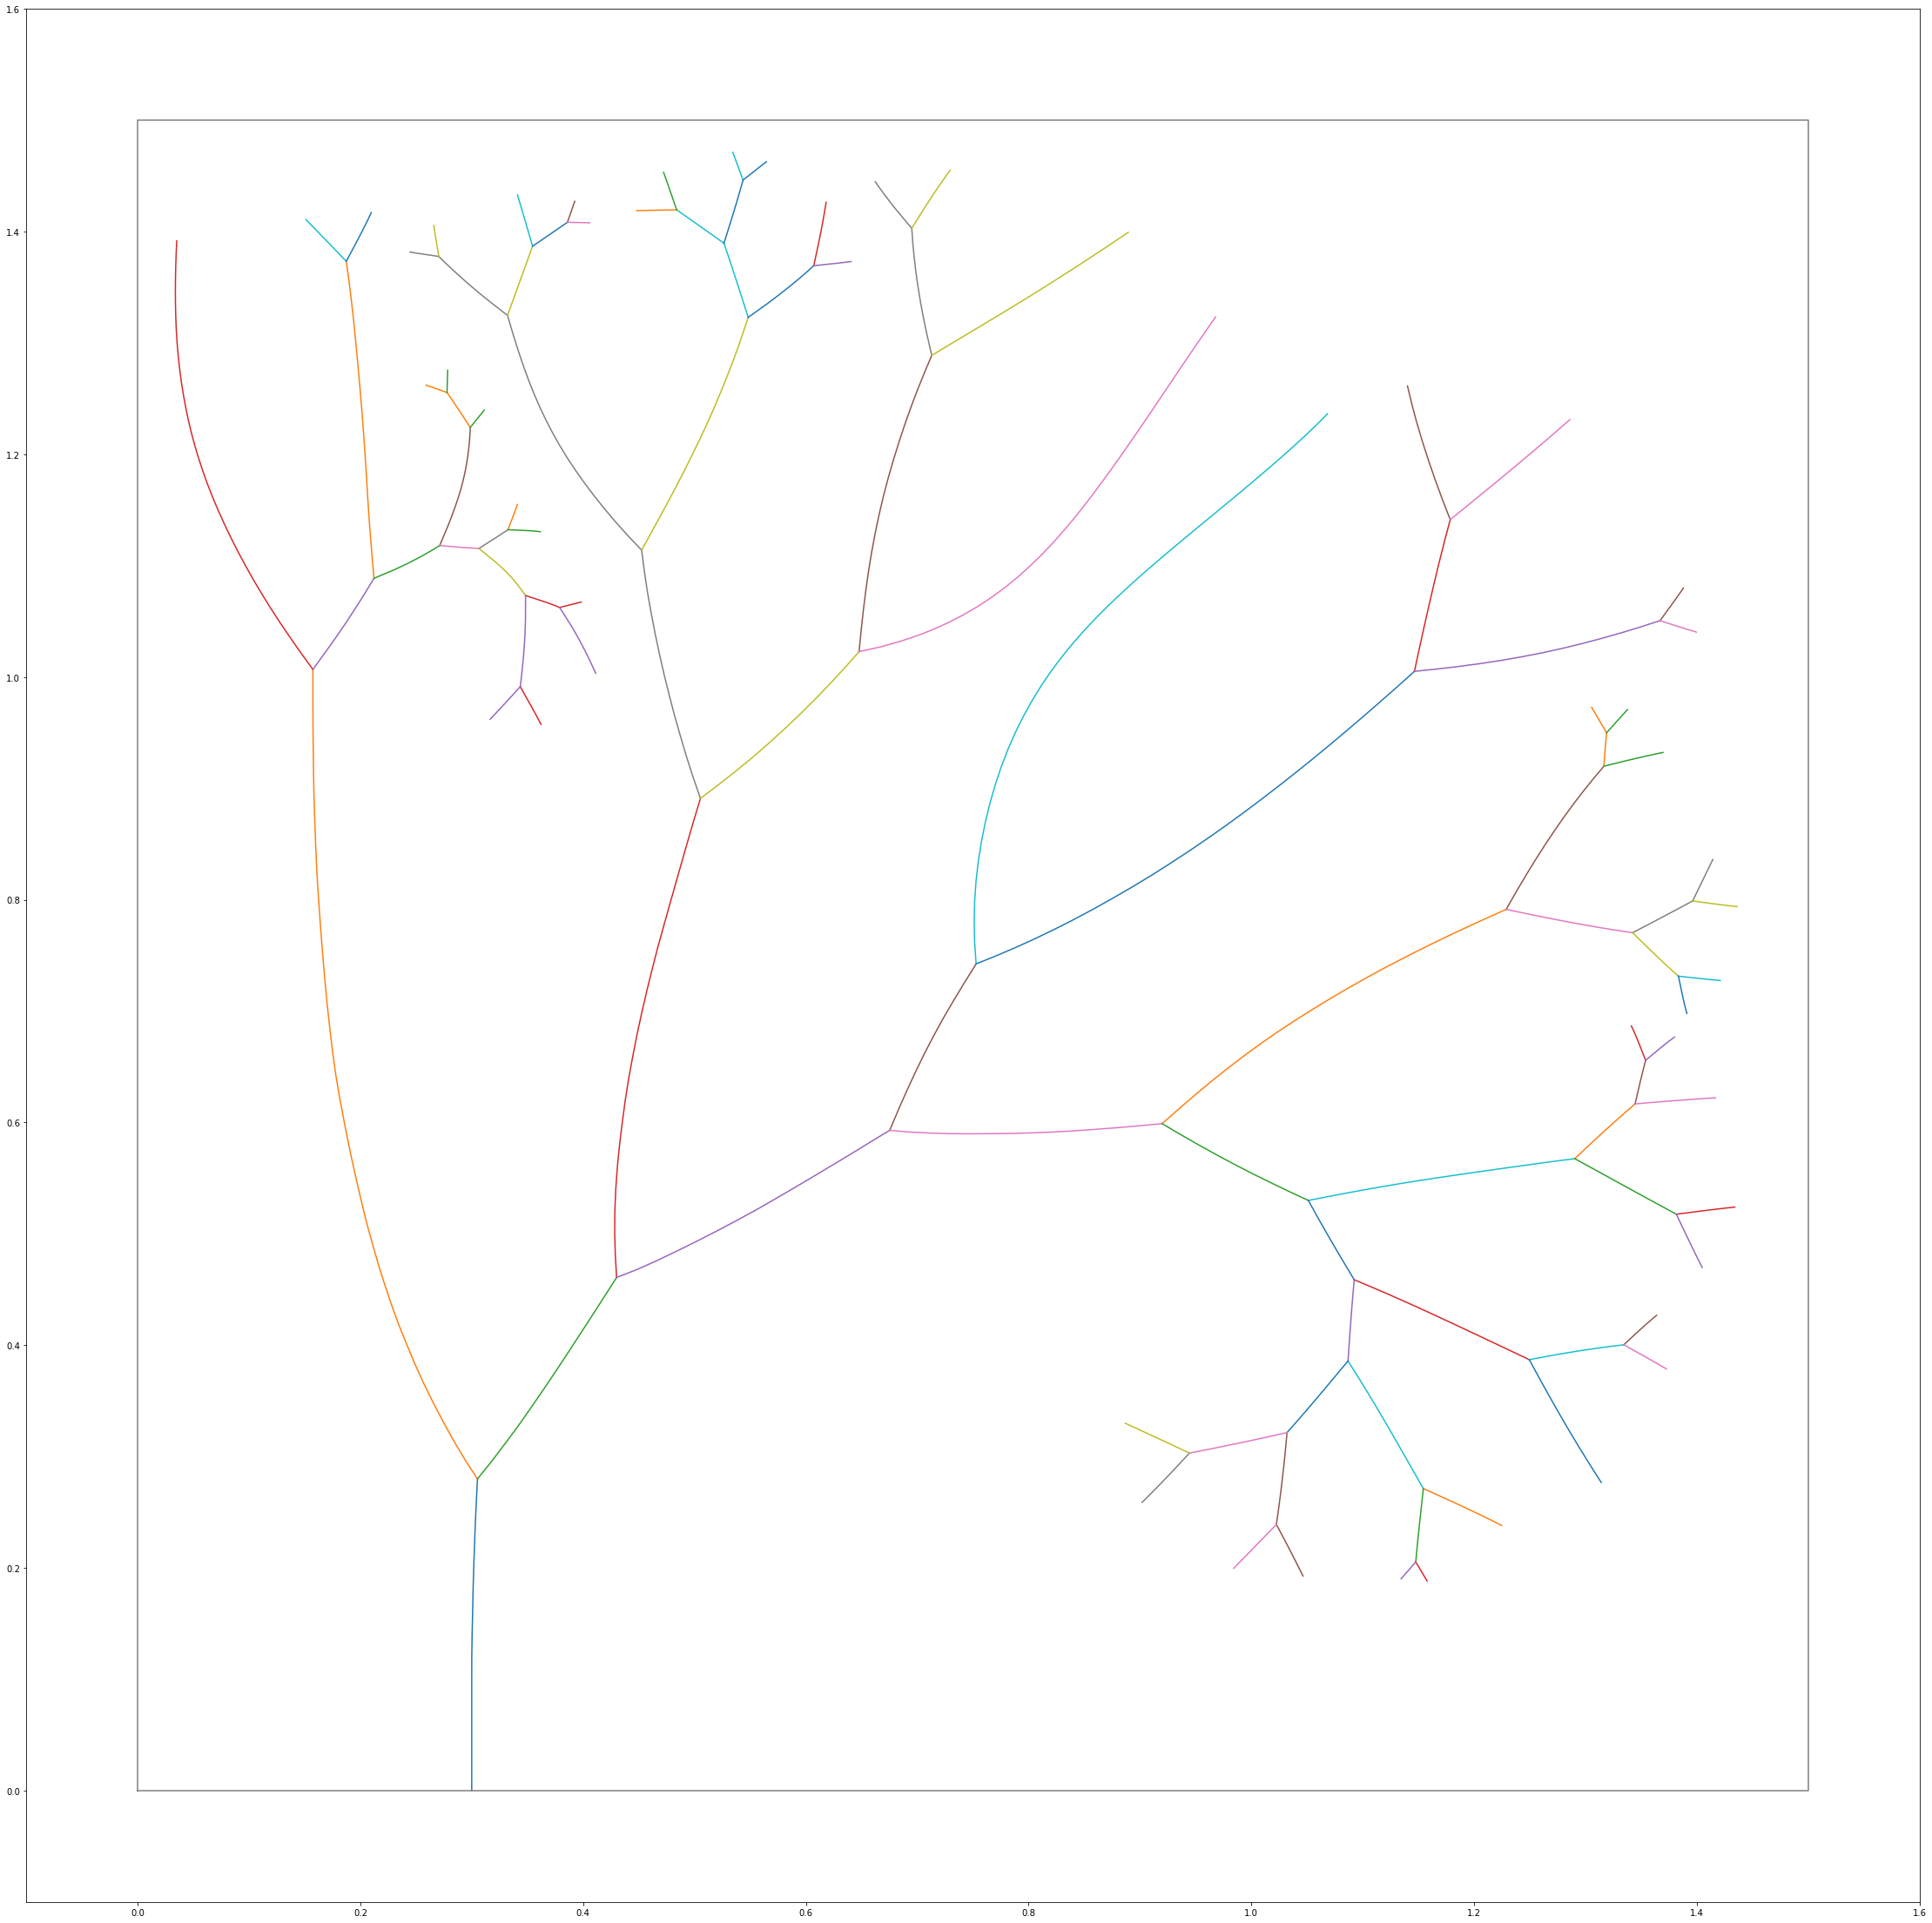

In [46]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 0.5

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_0.5.json")

plt.gcf().savefig("poisson_field_eta_0.5.png")

0
10
20
30
40
50
60
70
80
{'bound_gen_t': array([-6.93798065e-05, -5.17368317e-05, -4.91142273e-05, -5.55515289e-05,
       -5.72204590e-05, -1.06811523e-04, -5.88893890e-05, -7.77244568e-05,
       -5.93662262e-05, -7.55786896e-05, -7.79628754e-05, -6.72340393e-05,
       -7.03334808e-05, -7.55786896e-05, -8.65459442e-05, -7.74860382e-05,
       -7.89165497e-05, -8.46385956e-05, -8.58306885e-05, -1.06573105e-04,
       -9.77516174e-05, -1.11818314e-04, -9.20295715e-05, -1.35421753e-04,
       -1.96218491e-04, -1.18255615e-04, -1.59263611e-04, -1.35183334e-04,
       -1.31845474e-04, -1.33037567e-04, -1.44720078e-04, -1.35660172e-04,
       -1.39236450e-04, -1.70230865e-04, -2.39849091e-04, -1.94787979e-04,
       -2.04086304e-04, -4.54664230e-04, -2.62022018e-04, -2.29597092e-04,
       -2.59637833e-04, -2.75850296e-04, -2.76803970e-04, -3.04460526e-04,
       -3.53097916e-04, -3.20672989e-04, -3.22818756e-04, -3.85761261e-04,
       -3.86476517e-04, -4.11033630e-04, -4.51087952e-04, 

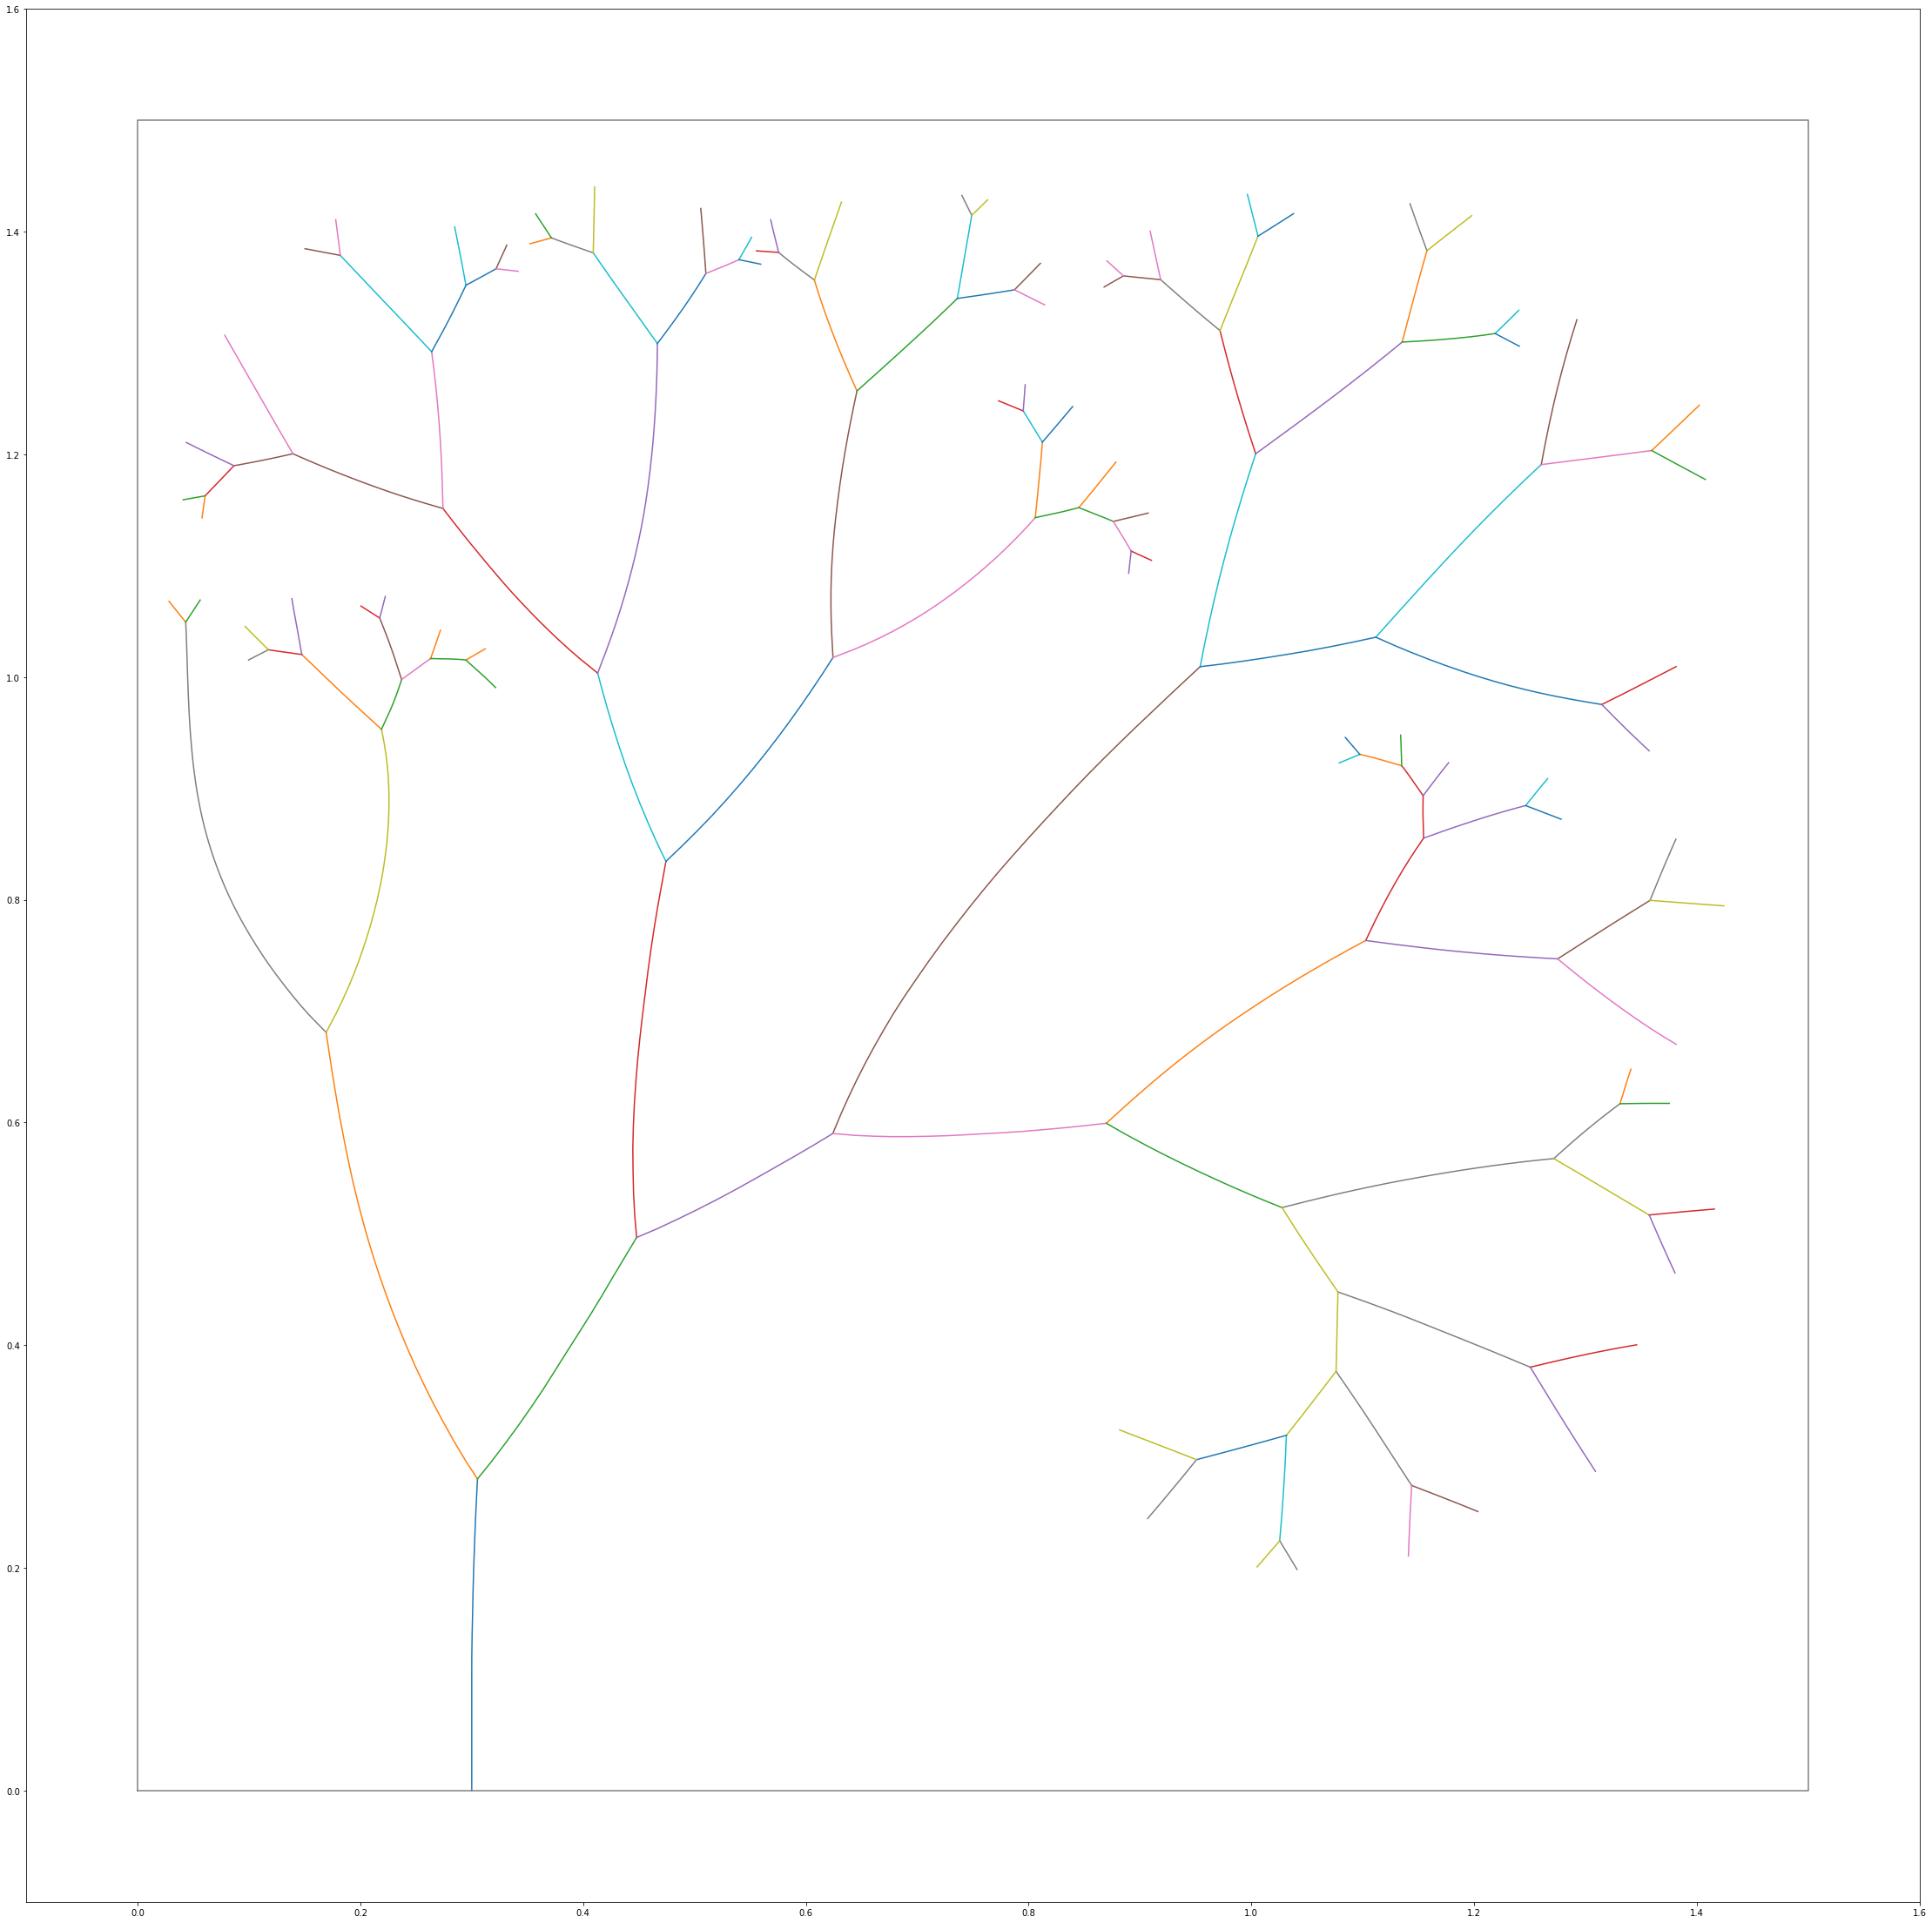

In [47]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 1

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_1.json")

plt.gcf().savefig("poisson_field_eta_1.png")

0
10
20
30
40
50
60
70
80
90
{'bound_gen_t': array([-6.62803650e-05, -5.38825989e-05, -5.12599945e-05, -5.22136688e-05,
       -8.01086426e-05, -5.86509705e-05, -5.88893890e-05, -8.67843628e-05,
       -6.00814819e-05, -8.34465027e-05, -7.31945038e-05, -6.55651093e-05,
       -7.20024109e-05, -7.58171082e-05, -8.70227814e-05, -7.86781311e-05,
       -7.96318054e-05, -8.10623169e-05, -8.44001770e-05, -1.02996826e-04,
       -1.42335892e-04, -1.13010406e-04, -1.16586685e-04, -1.15156174e-04,
       -1.15871429e-04, -1.32799149e-04, -1.23739243e-04, -1.51872635e-04,
       -1.56879425e-04, -1.59978867e-04, -1.92642212e-04, -1.76191330e-04,
       -2.06232071e-04, -1.72853470e-04, -2.01463699e-04, -1.81198120e-04,
       -1.94549561e-04, -2.22921371e-04, -2.23875046e-04, -2.34127045e-04,
       -2.38895416e-04, -2.68220901e-04, -4.12940979e-04, -2.52723694e-04,
       -3.40700150e-04, -3.73840332e-04, -3.20434570e-04, -3.34024429e-04,
       -3.80754471e-04, -4.32729721e-04, -4.87565994e-0

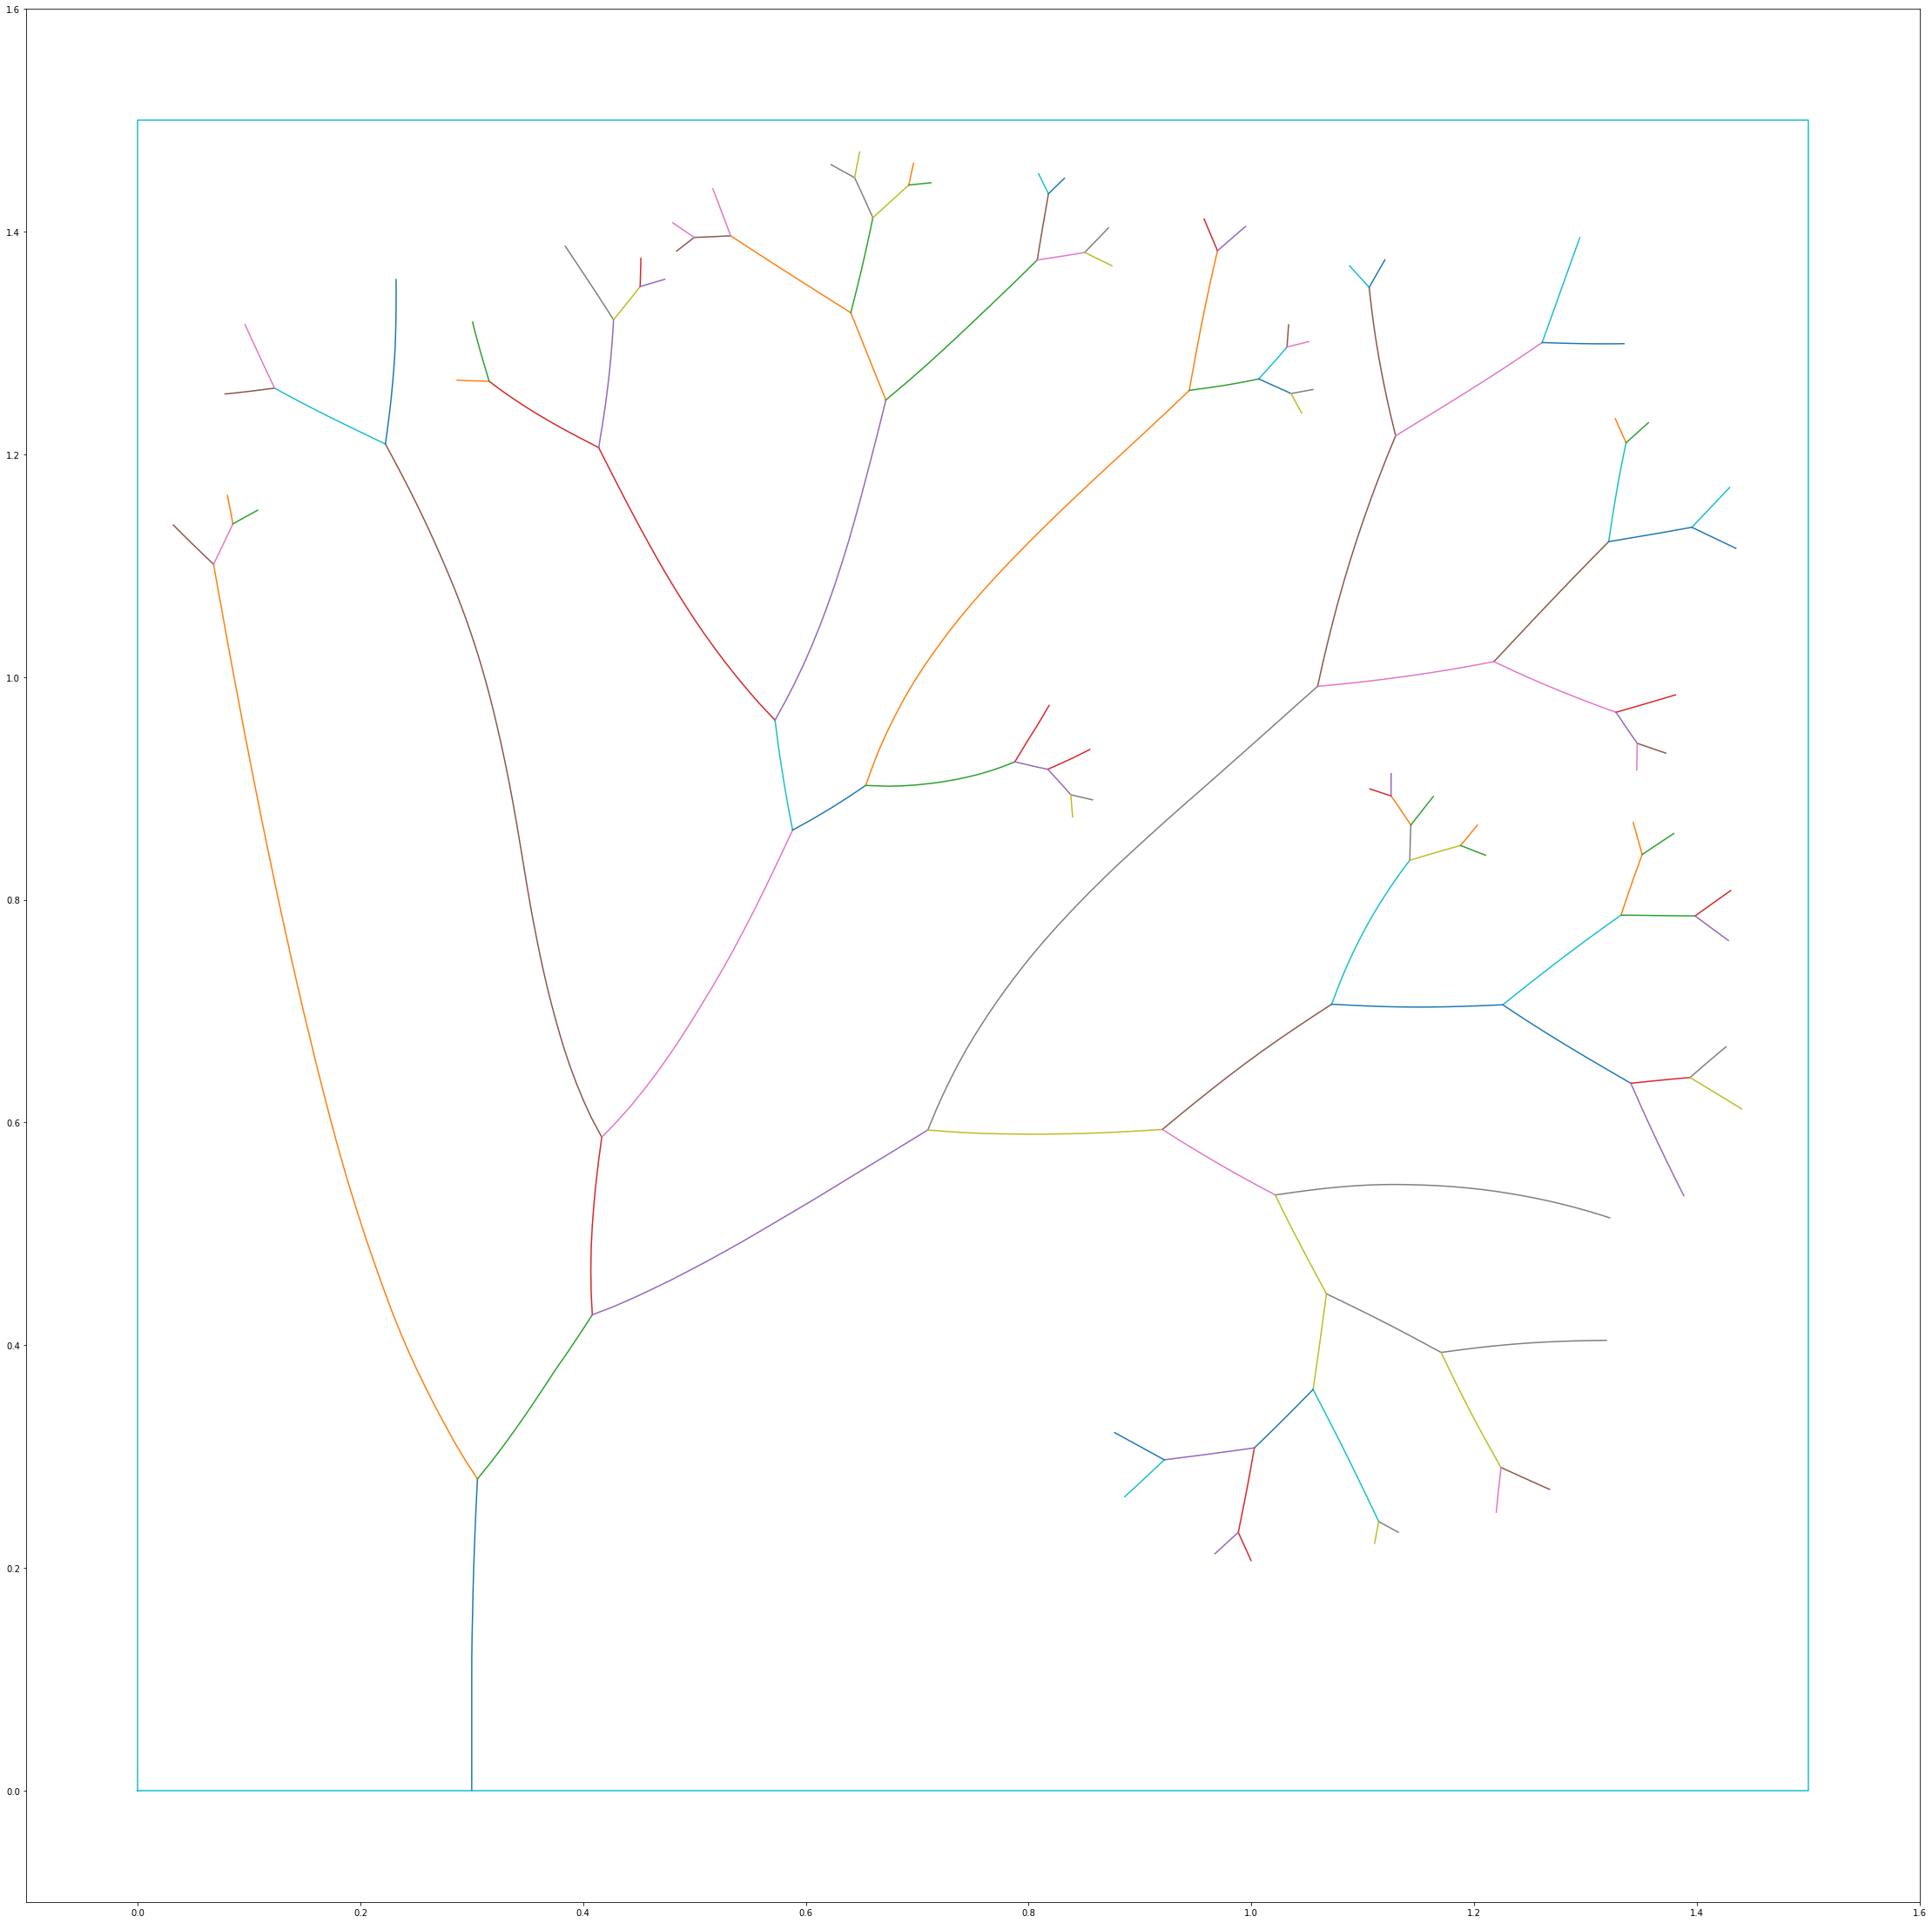

In [48]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 1.5

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_1.5.json")

plt.gcf().savefig("poisson_field_eta_1.5.png")

0
10
20
30
40
50
60
70
80
90
{'bound_gen_t': array([-5.81741333e-05, -5.24520874e-05, -5.03063202e-05, -5.60283661e-05,
       -8.32080841e-05, -6.07967377e-05, -1.21593475e-04, -5.65052032e-05,
       -5.62667847e-05, -6.31809235e-05, -7.10487366e-05, -7.27176666e-05,
       -1.02281570e-04, -7.46250153e-05, -7.43865967e-05, -8.48770142e-05,
       -9.17911530e-05, -8.91685486e-05, -8.41617584e-05, -8.48770142e-05,
       -9.34600830e-05, -1.03712082e-04, -1.30653381e-04, -1.10387802e-04,
       -1.13010406e-04, -1.16109848e-04, -1.66177750e-04, -1.72376633e-04,
       -1.69277191e-04, -1.87635422e-04, -1.31845474e-04, -1.64747238e-04,
       -1.71184540e-04, -2.20298767e-04, -1.94549561e-04, -1.98841095e-04,
       -2.24828720e-04, -2.00986862e-04, -2.13861465e-04, -2.21252441e-04,
       -2.46047974e-04, -2.50101089e-04, -2.51770020e-04, -2.46524811e-04,
       -3.62157822e-04, -3.61204147e-04, -3.06129456e-04, -3.16381454e-04,
       -3.30448151e-04, -4.10079956e-04, -6.45875931e-0

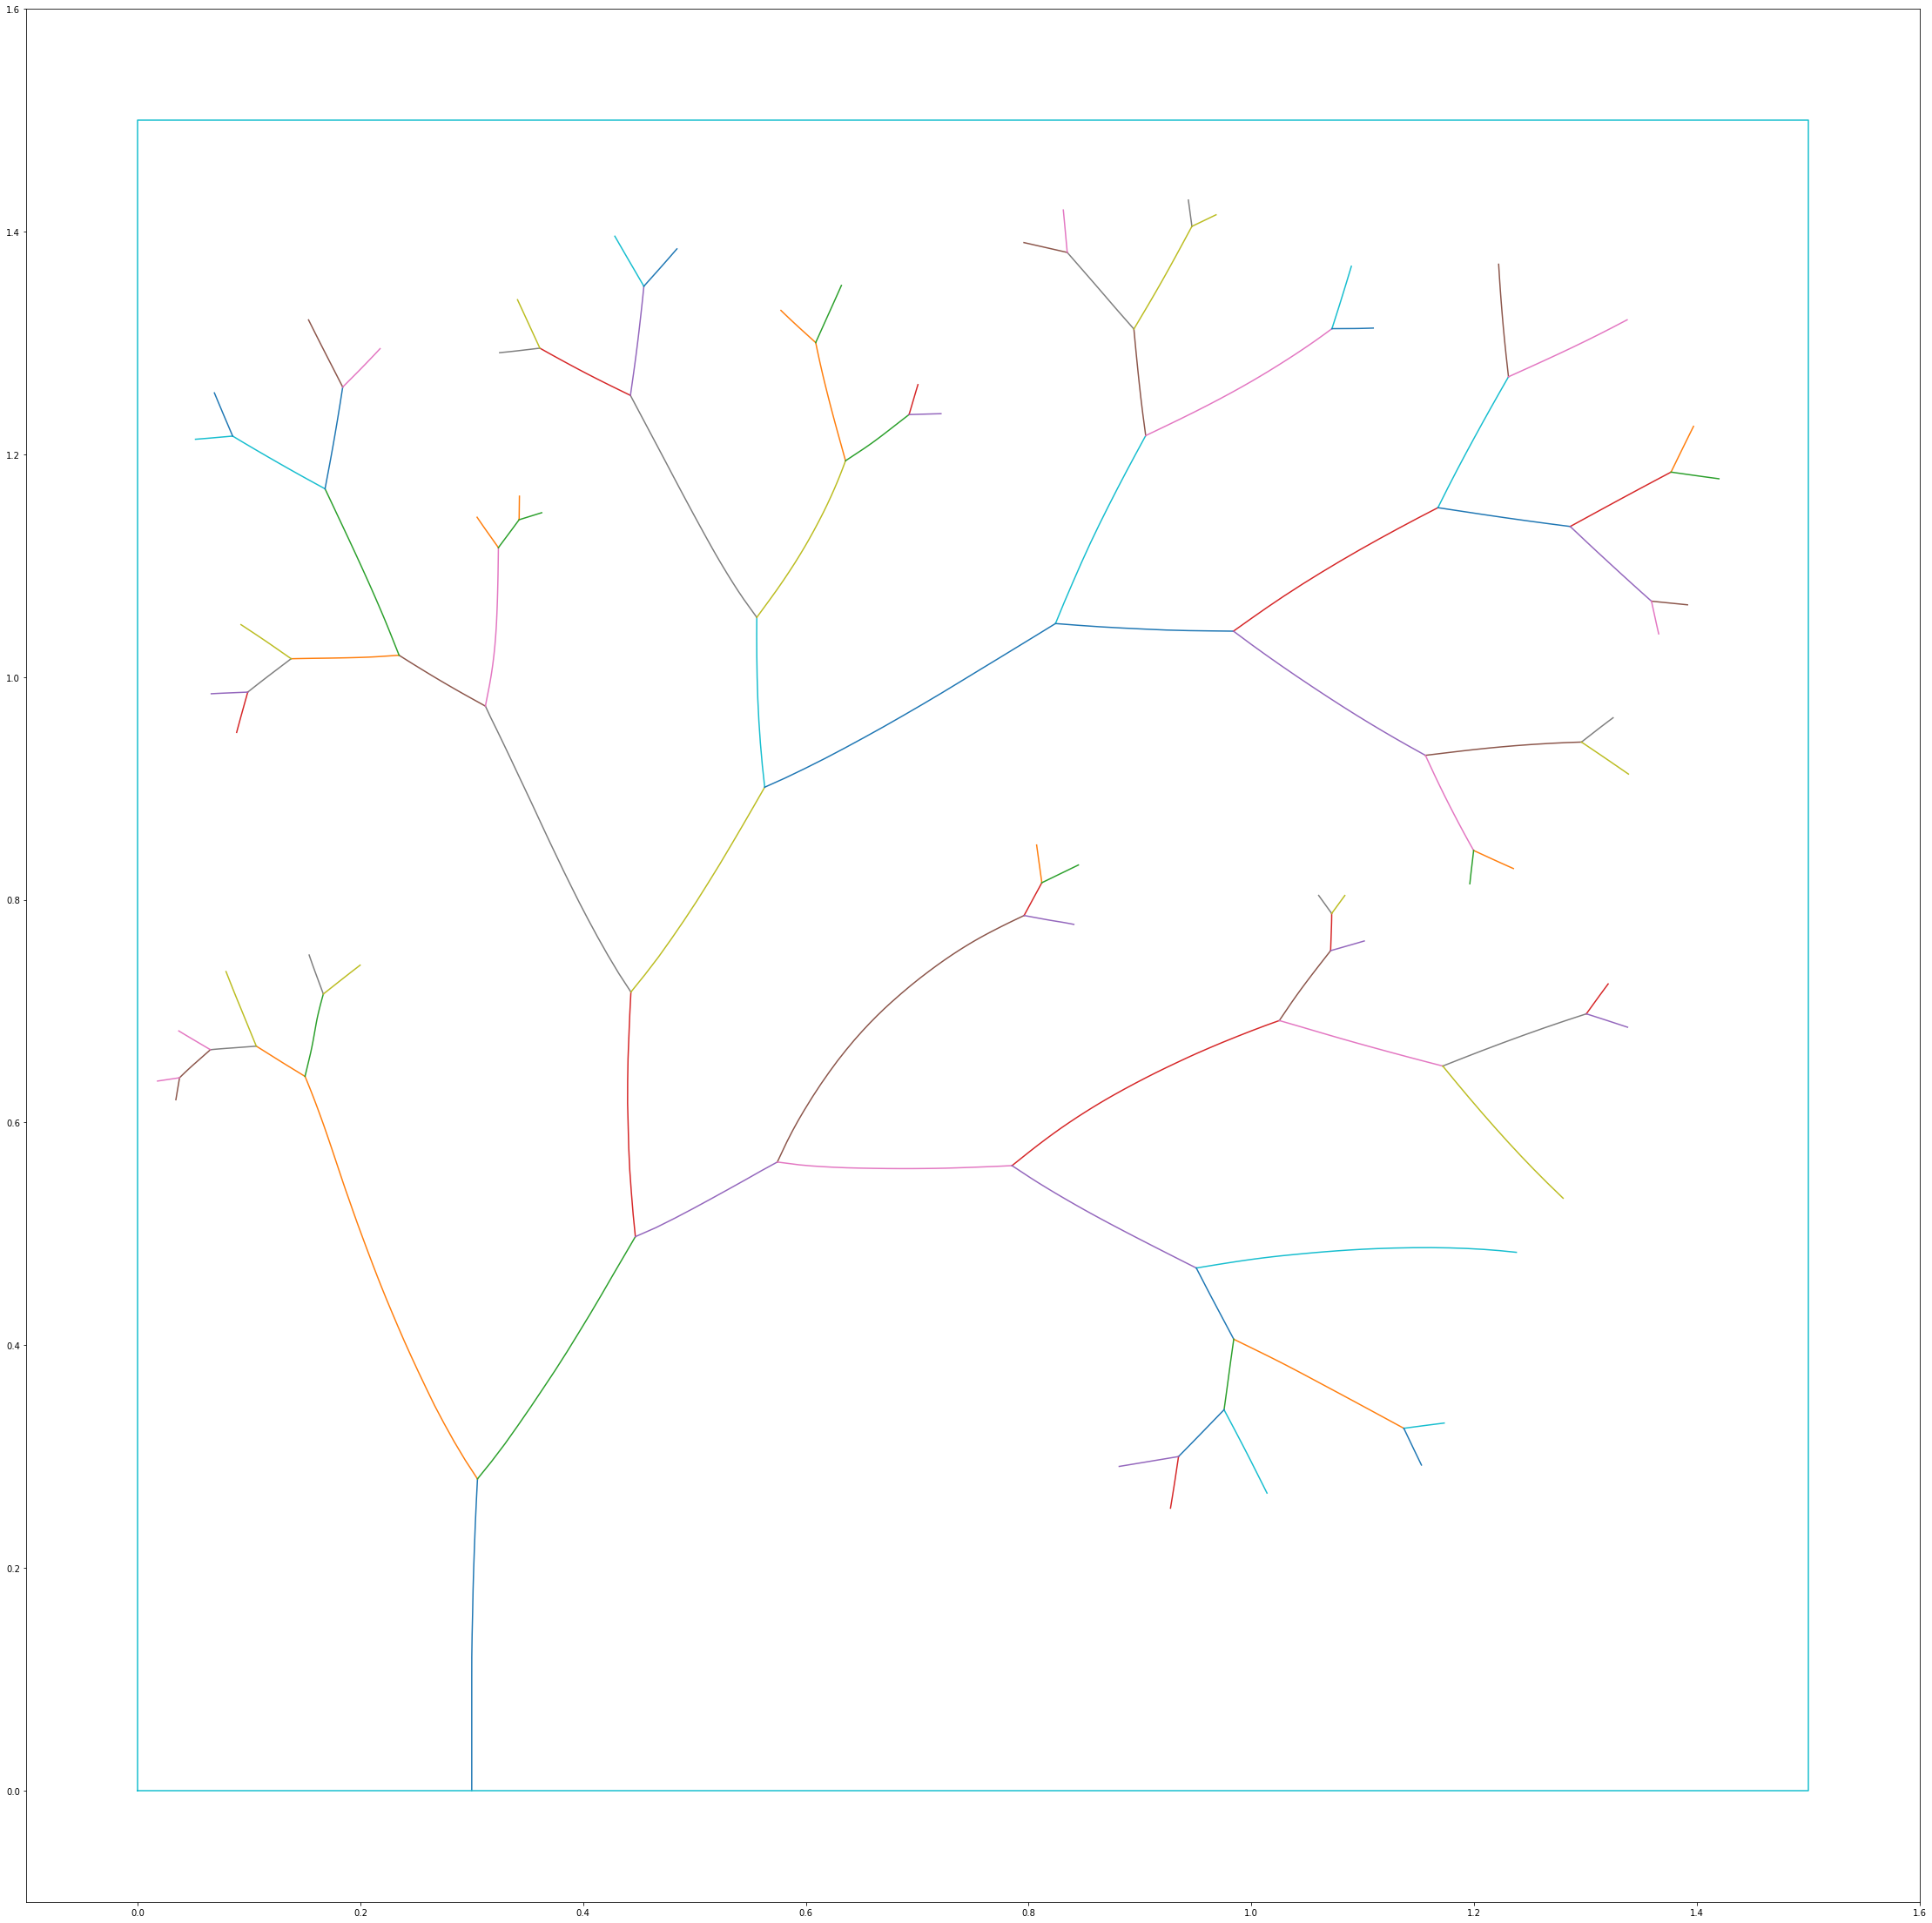

In [49]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 2

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_2.json")

plt.gcf().savefig("poisson_field_eta_2.png")

0
10
20
30
40
50
60
70
80
90
100

{'bound_gen_t': array([-5.31673431e-05, -5.05447388e-05, -7.79628754e-05, -5.26905060e-05,
       -5.38825989e-05, -5.93662262e-05, -5.43594360e-05, -5.55515289e-05,
       -5.60283661e-05, -5.60283661e-05, -6.91413879e-05, -6.89029694e-05,
       -1.01327896e-04, -7.48634338e-05, -8.27312469e-05, -8.36849213e-05,
       -9.01222229e-05, -8.36849213e-05, -8.44001770e-05, -1.27792358e-04,
       -9.17911530e-05, -1.05619431e-04, -1.14202499e-04, -1.17778778e-04,
       -1.42097473e-04, -1.23977661e-04, -2.14099884e-04, -1.85251236e-04,
       -1.26600266e-04, -1.42335892e-04, -1.73091888e-04, -1.39713287e-04,
       -1.47581100e-04, -1.57117844e-04, -1.65700912e-04, -1.90019608e-04,
       -2.05039978e-04, -2.04563141e-04, -2.18629837e-04, -2.86340714e-04,
       -3.28302383e-04, -2.53438950e-04, -2.90632248e-04, -2.92301178e-04,
       -4.04119492e-04, -3.42369080e-04, -3.51190567e-04, -5.49554825e-04,
       -4.20570374e-04, -4.59432602e-04, -5.912780

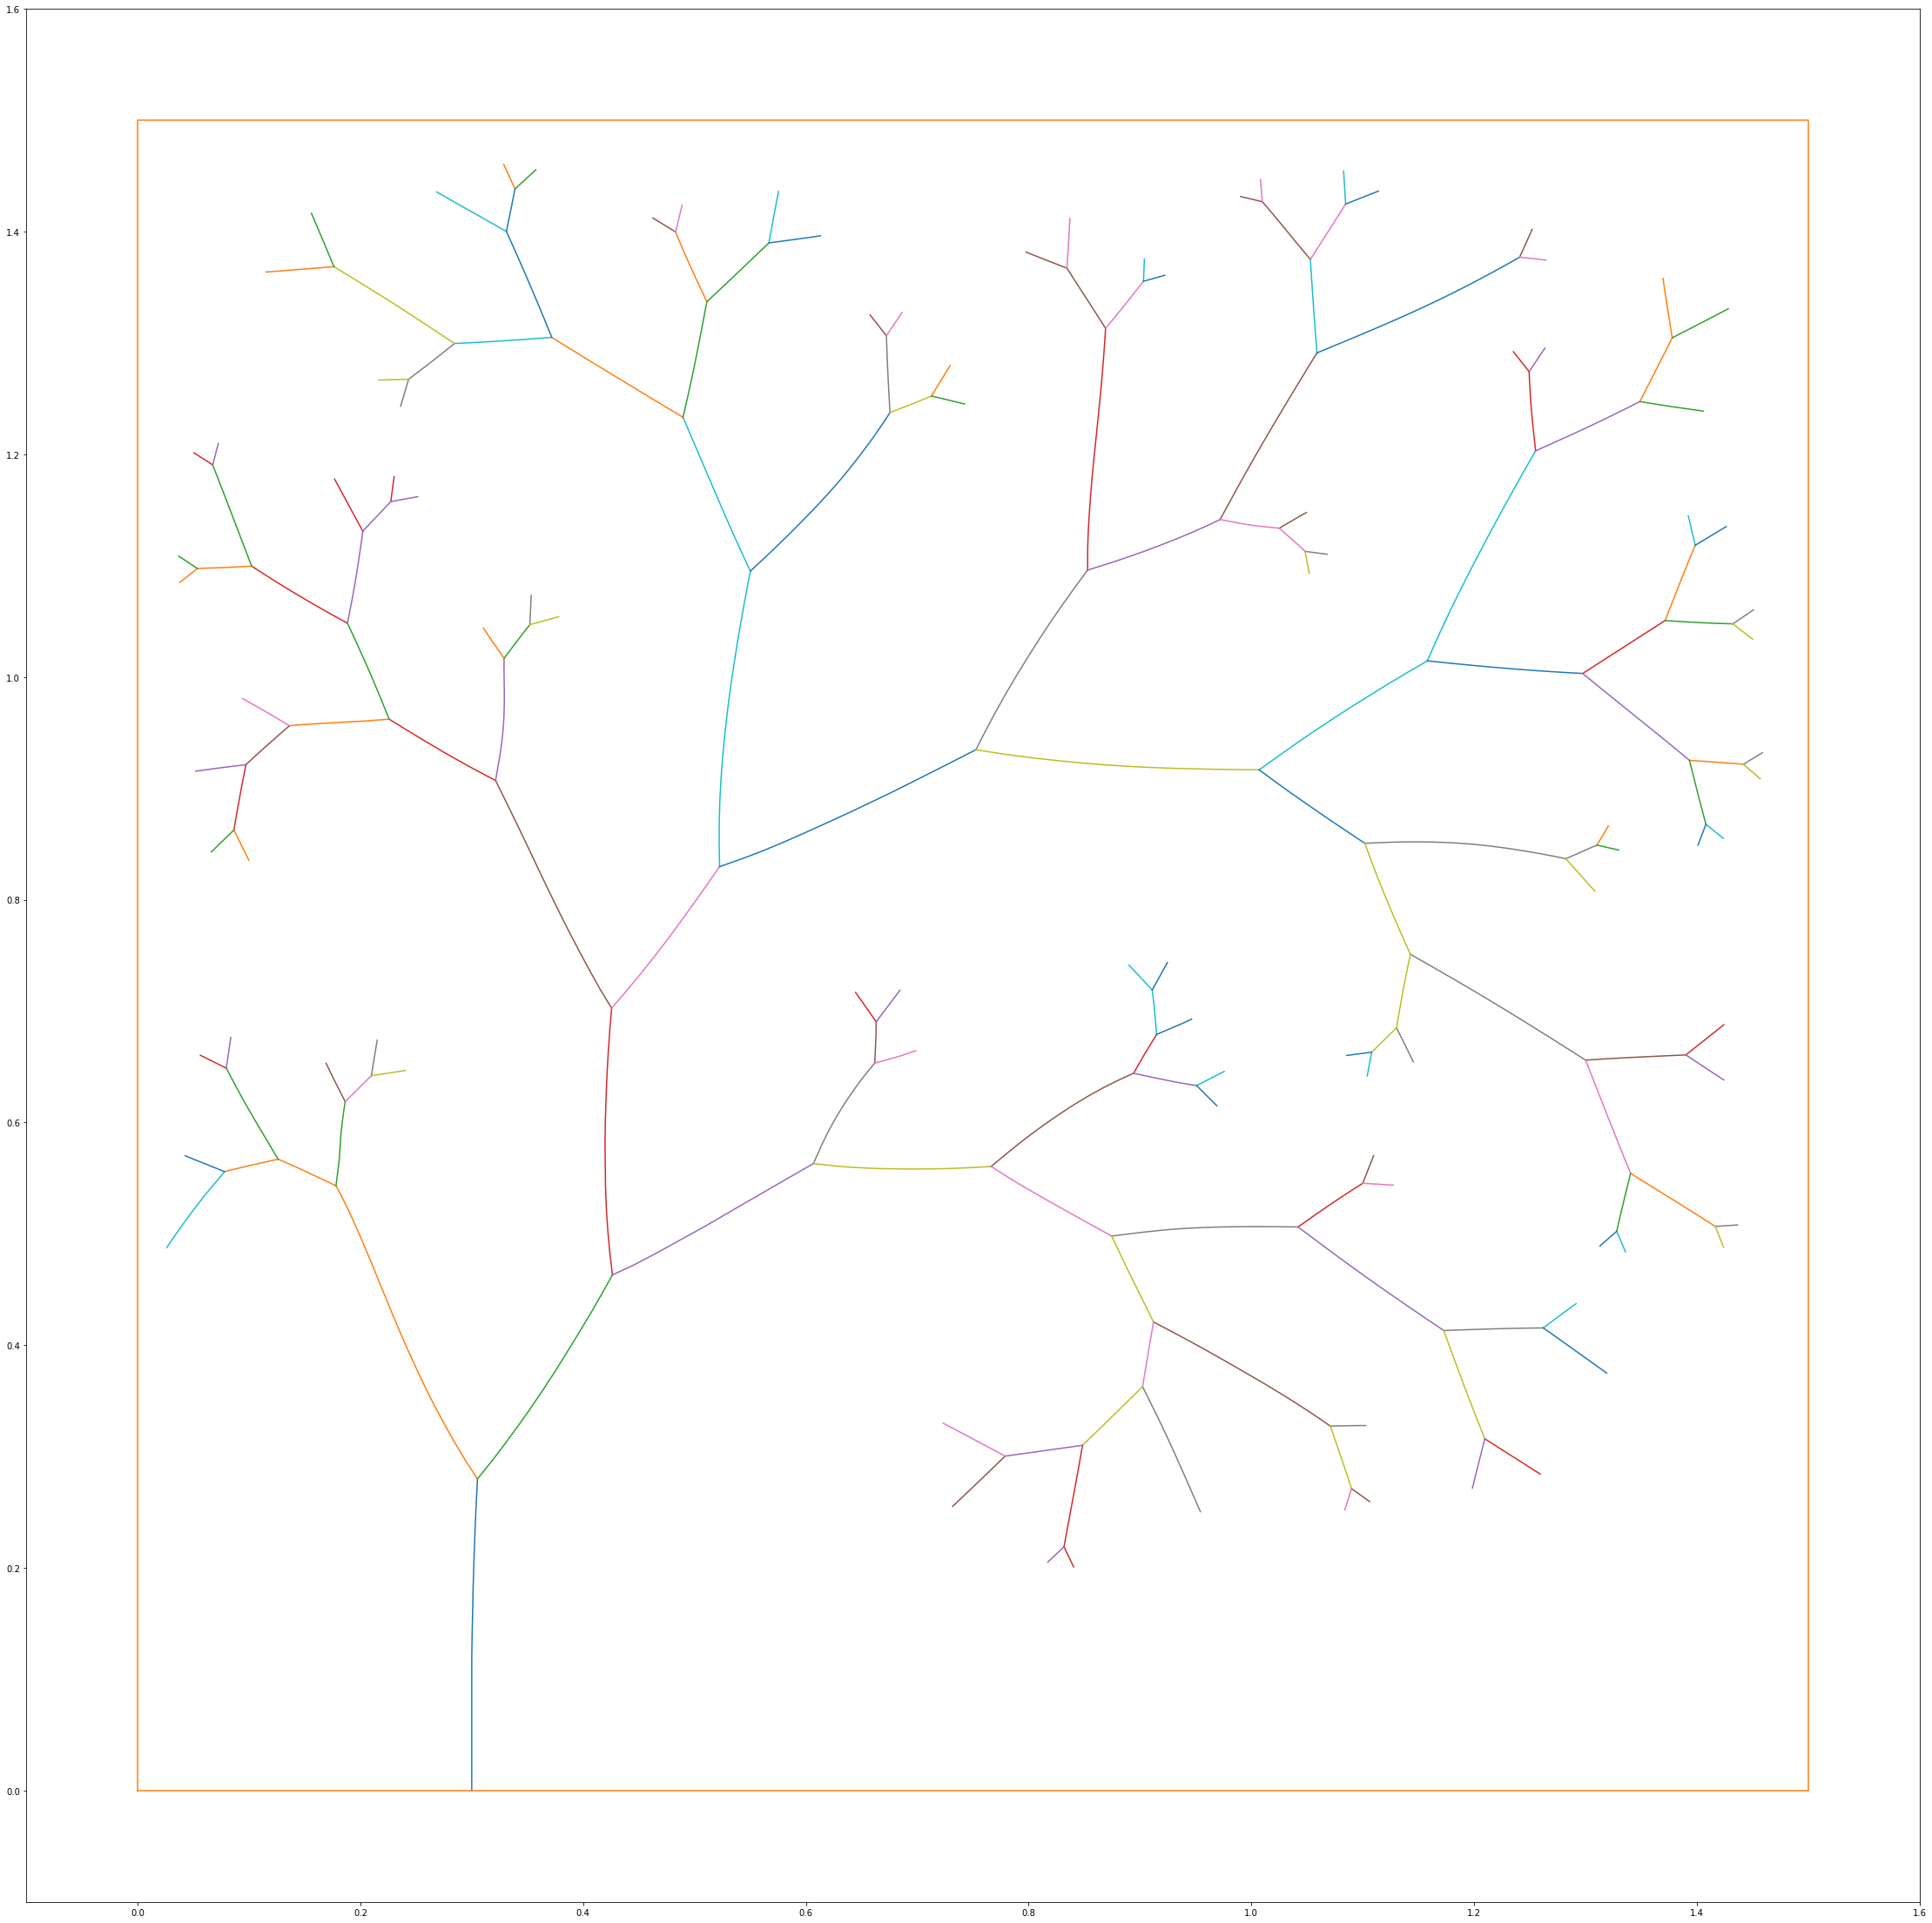

In [50]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 2.5

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_2.5.json")

plt.gcf().savefig("poisson_field_eta_2.5.png")

0
10
20
30
40
50
60
70
80
90
100

110
{'bound_gen_t': array([-9.65595245e-05, -9.51290131e-05, -8.86917114e-05, -5.53131104e-05,
       -5.38825989e-05, -5.86509705e-05, -6.53266907e-05, -5.93662262e-05,
       -7.91549683e-05, -1.06334686e-04, -7.10487366e-05, -6.77108765e-05,
       -1.15156174e-04, -7.39097595e-05, -8.24928284e-05, -1.08480453e-04,
       -8.60691071e-05, -7.79628754e-05, -1.06573105e-04, -9.17911530e-05,
       -1.28030777e-04, -8.94069672e-05, -9.36985016e-05, -1.04665756e-04,
       -1.14202499e-04, -1.89065933e-04, -1.27315521e-04, -1.32083893e-04,
       -1.40666962e-04, -1.20401382e-04, -1.28746033e-04, -1.36375427e-04,
       -2.11715698e-04, -1.59978867e-04, -1.63555145e-04, -1.70230865e-04,
       -1.71899796e-04, -1.94549561e-04, -2.20298767e-04, -2.22682953e-04,
       -2.49385834e-04, -2.88486481e-04, -3.52382660e-04, -3.38554382e-04,
       -3.14474106e-04, -3.79800797e-04, -3.48806381e-04, -3.76224518e-04,
       -5.05208969e-04, -5.99384308e-04, -4.69

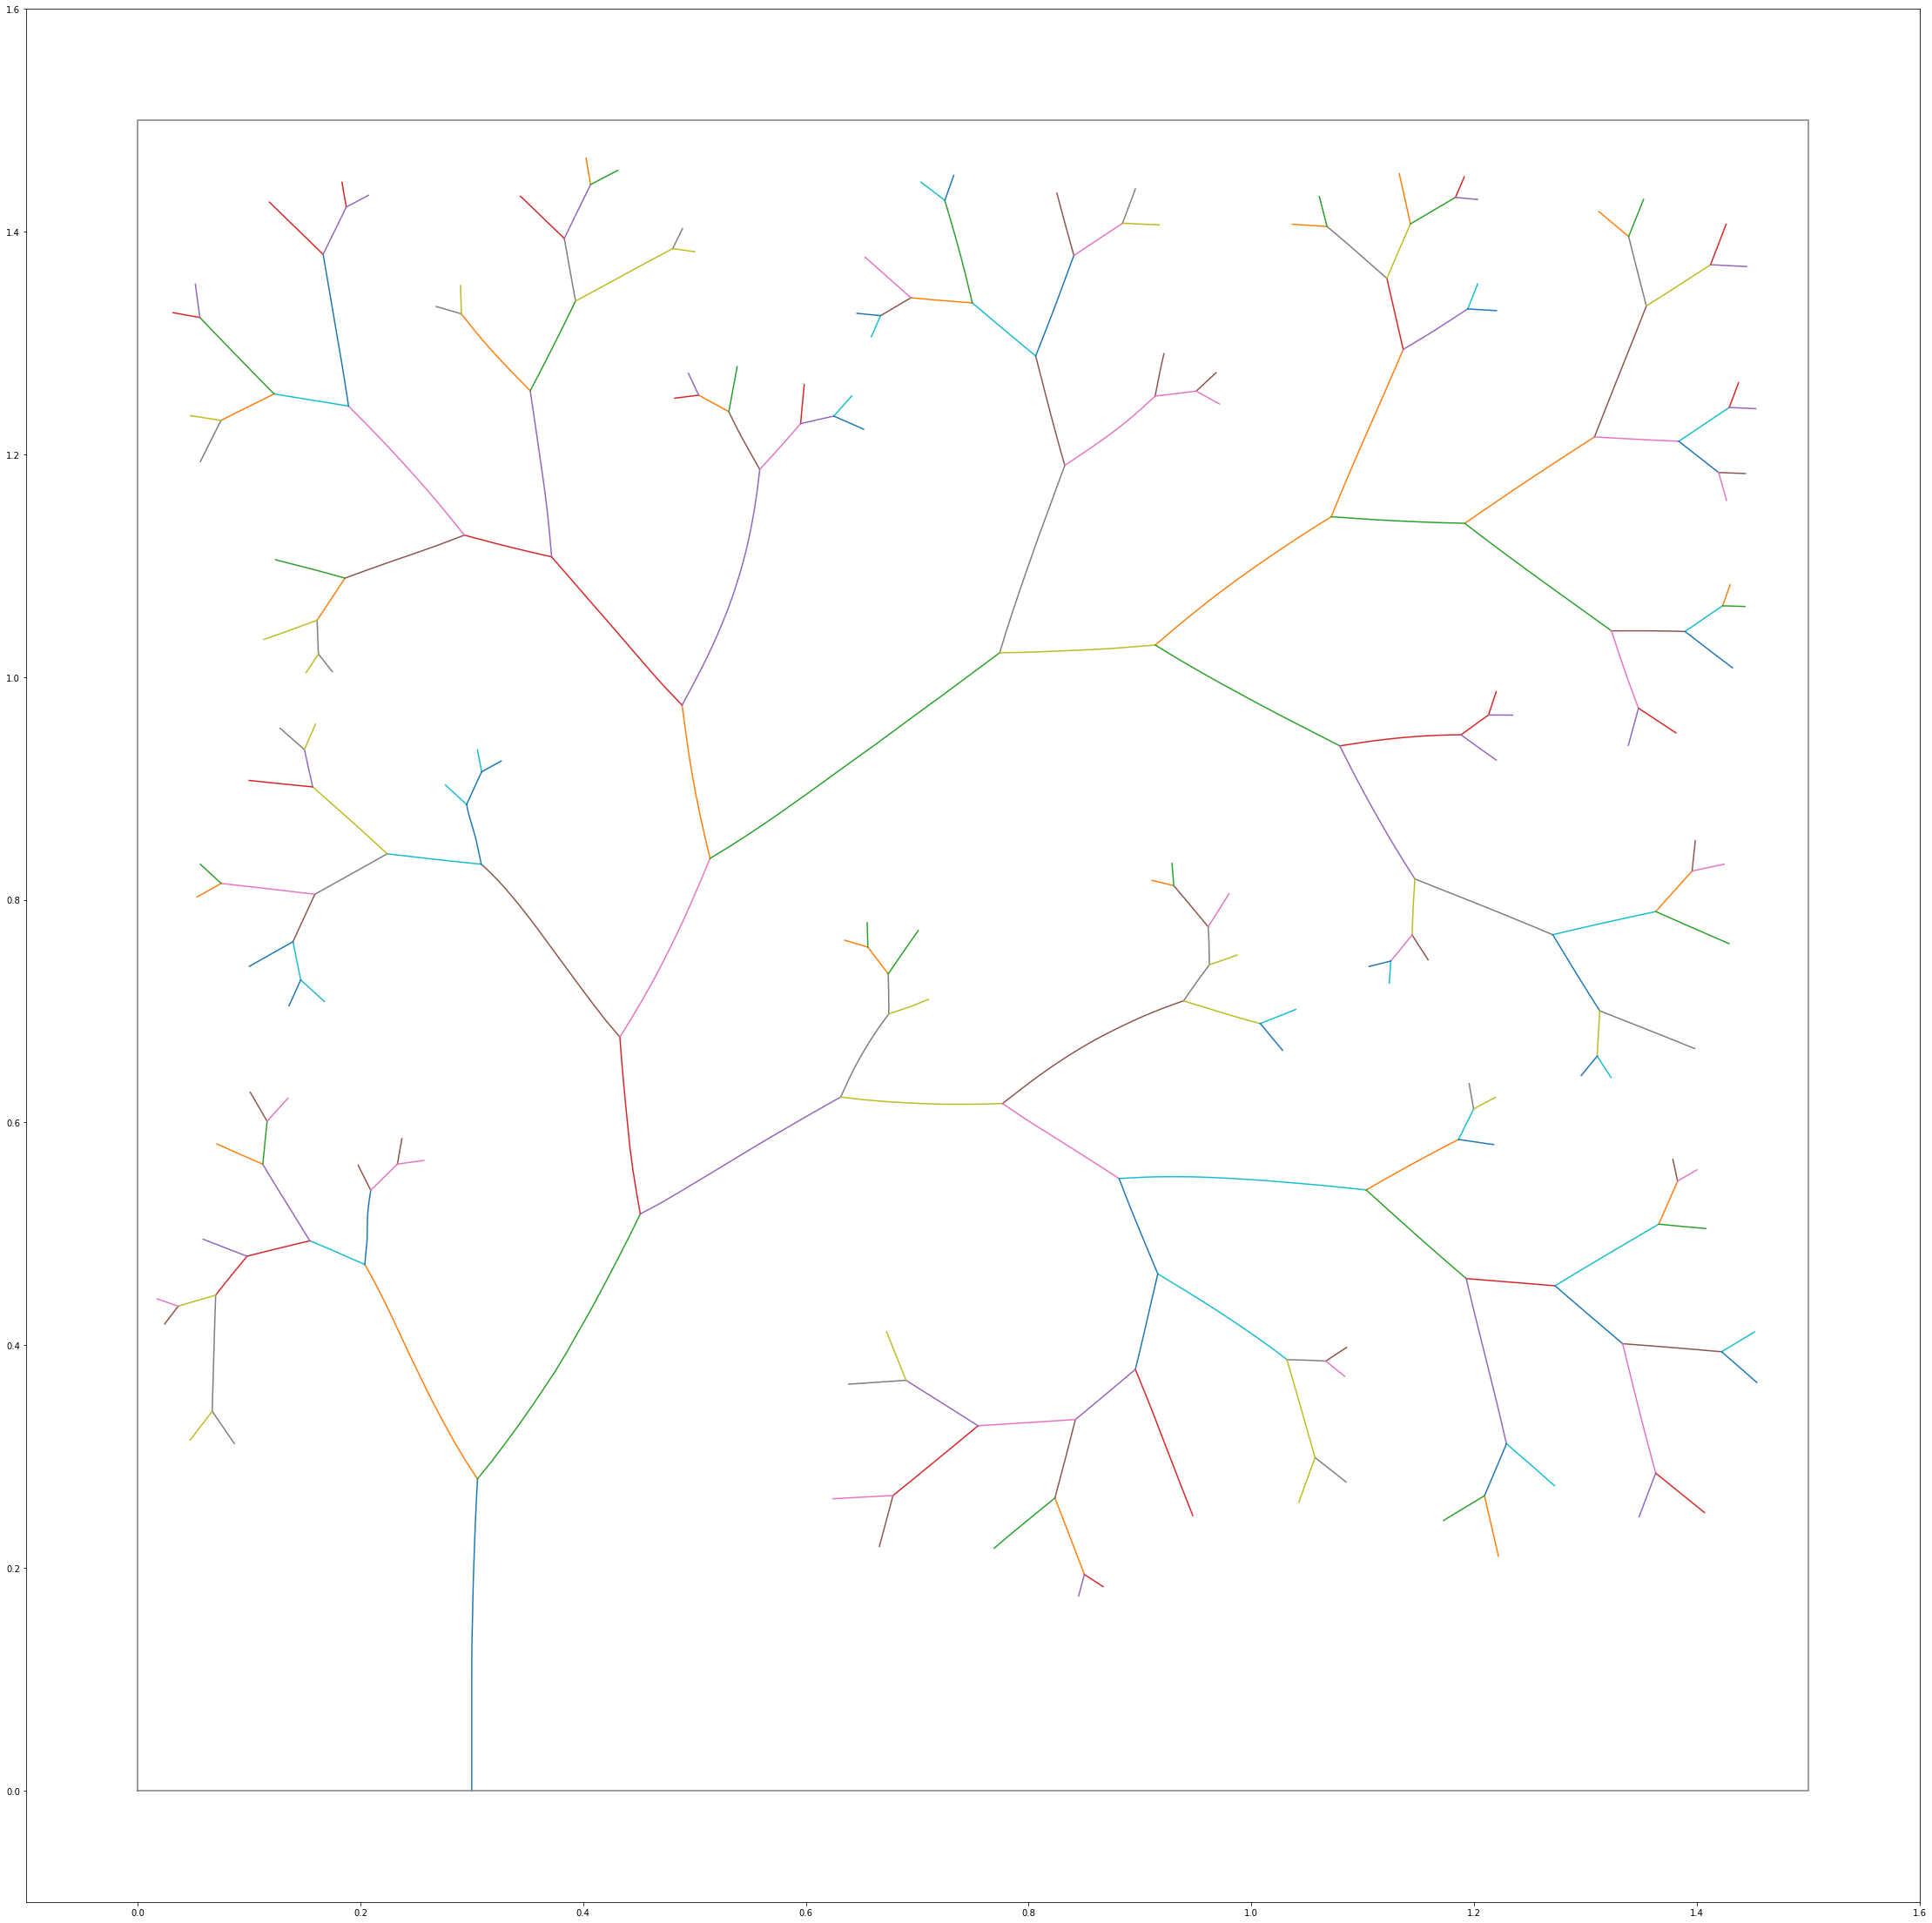

In [51]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 1.5
m.width = 1.5
m.dx = 0.3
m.number_of_steps = 400
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 3

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializePoisson()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "poisson_field_eta_3.json")

plt.gcf().savefig("poisson_field_eta_3.png")

## Big Laplacian Field Simulation

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
{'bound_gen_t': array([-7.31945038e-05, -5.34057617e-05, -6.60419464e-05, -3.57627869e-05,
       -4.07695770e-05, -3.83853912e-05, -3.74317169e-05, -3.93390656e-05,
       -3.86238098e-05, -4.45842743e-05, -6.00814819e-05, -4.33921814e-05,
       -6.27040863e-05, -9.65595245e-05, -5.07831573e-05, -5.22136688e-05,
       -5.14984131e-05, -5.29289246e-05, -1.71184540e-04, -6.69956207e-05,
       -6.79492950e-05, -6.69956207e-05, -6.74724579e-05, -7.20024109e-05,
       -7.36713409e-05, -7.65323639e-05, -7.86781311e-05, -7.86781311e-05,
       -8.22544098e-05, -1.15156174e-04, -1.34706497e-04, -1.50680542e-04,
       -1.12533569e-04, -1.05381012e-04, -1.11818314e-04, -1.17540359e-04,
       -1.89542770e-04, -1.18494034e-04, -1.23739243e-04, -1.44720078e-04,
       -1.27315521e-04, -1.96456909e-04, -1.32560730e-04, -2.75850296e-04,
       -1.41859055e-04, -1.55687332e-04, -2.73942947e-04, -1.59502029e-04,
      

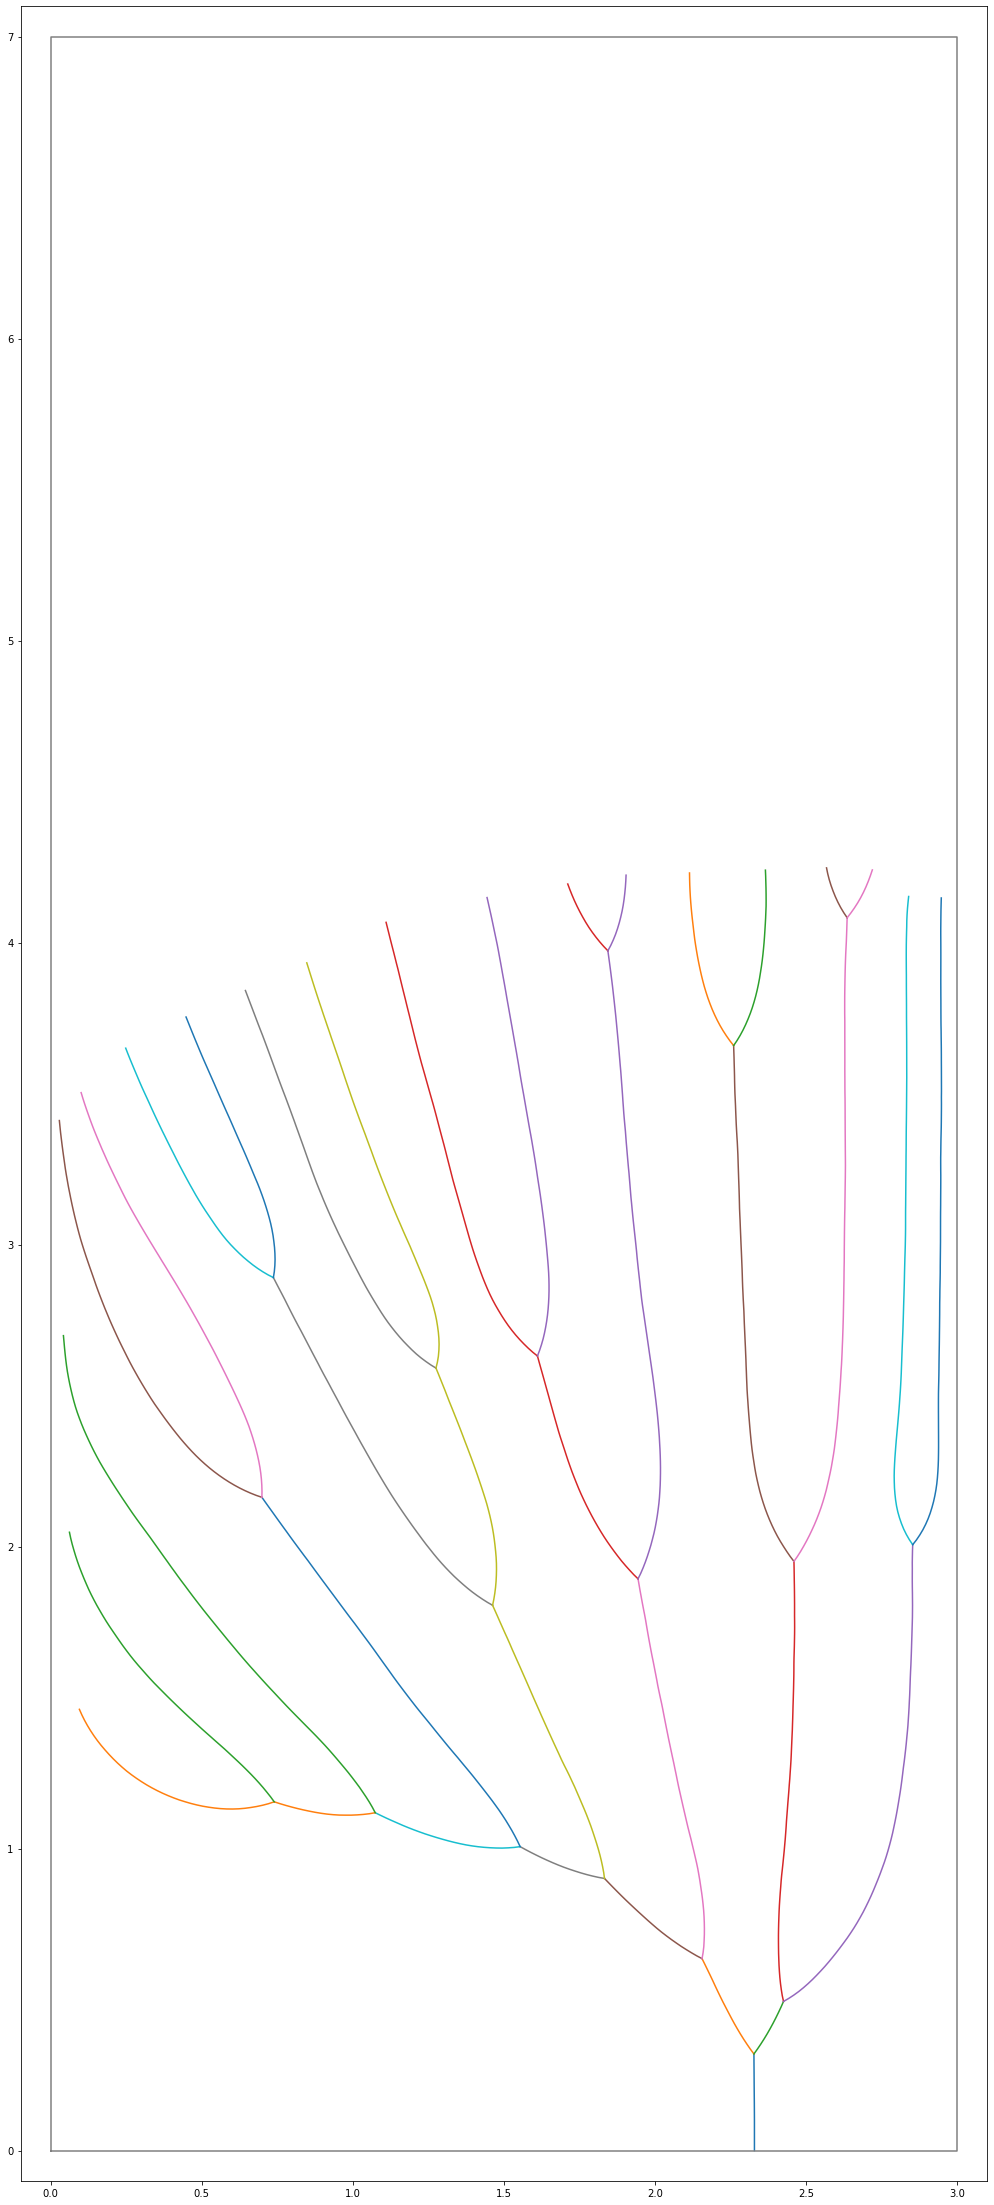

In [56]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 7
m.width = 3
m.dx = 2.33
m.number_of_steps = 500
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 0

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_big_field_eta_" + str(m.eta) + ".json")
plt.gcf().savefig("laplacian_big_field_eta_" + str(m.eta) + ".png")

In [57]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 7
m.width = 3
m.dx = 2.33
m.number_of_steps = 500
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 1

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_big_field_eta_" + str(m.eta) + ".json")
plt.gcf().savefig("laplacian_big_field_eta_" + str(m.eta) + ".png")

0
10
20
30
40
50
60
70
80
90
100

110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320


In [ ]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 7
m.width = 3
m.dx = 2.33
m.number_of_steps = 500
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 2

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_big_field_eta_" + str(m.eta) + ".json")
plt.gcf().savefig("laplacian_big_field_eta_" + str(m.eta) + ".png")

In [ ]:
import riversimdefs
from riversim import *

import matplotlib.pyplot as plt



m = Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
m.growth_type = 0
#has impact on performance
m.height = 7
m.width = 3
m.dx = 2.33
m.number_of_steps = 500
m.mesh_params.refinment_radius = 0.01
m.mesh_params.min_area = 1e-9

m.eta = 3

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(Polar(0.1, 0), m.region_params.river_boundary_id)

res = riversimdefs.growRiver(m, plot_period = 1, debug = False)
print(res)
save(m, "laplacian_big_field_eta_" + str(m.eta) + ".json")
plt.gcf().savefig("laplacian_big_field_eta_" + str(m.eta) + ".png")